In [65]:
import json
import copy
import random
import pickle
import math

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from BaseSVDD import BaseSVDD
from multiprocessing import Pool, cpu_count
from sklearn.decomposition import KernelPCA
from sklearn.metrics import roc_auc_score

In [13]:
# Openinng the JSON file
openAllData = open('data/train.json');
openTestData = open('data/test.json');

# returns JSON object as
# a dictionary
allData = json.load(openAllData);
testData = json.load(openTestData);

openAllData.close();
openTestData.close();

start an vocabulary and tfidf vectorizer

In [14]:
allData_str_list = []
for k1, v1 in allData.items():
    templist = []
    templist.append("year_" + str(v1["year"]))
    templist.append("venue_" + str(v1["venue"]))
    templist.extend(["keywords_" + str(keyword) for keyword in v1["keywords"]])
    templist.extend(["author_" + str(author) for author in v1["author"]])
    tempstr = ','.join(templist)
    allData_str_list.append(tempstr)  

In [15]:
allData_str_list[1007]

'year_2017,venue_5,keywords_449,keywords_455,keywords_136,keywords_457,keywords_203,keywords_11,keywords_278,keywords_87,keywords_27,keywords_156,keywords_94,keywords_425,keywords_107,keywords_427,keywords_430,keywords_432,keywords_433,keywords_177,author_2272,author_1603,author_1789'

In [16]:
NUM_YEAR = 20
START_YEAR = 2000
NUM_VENUE = 470
NUM_KEYWORDS = 500
NUM_AUTHOR = 2302
vocabulary = {}
vocab_index = 0
for i in range(NUM_YEAR):
    vocabulary["year_"+str(START_YEAR+i)] = vocab_index
    vocab_index+=1
for i in range(NUM_VENUE):
    vocabulary["venue_"+str(i)] = vocab_index
    vocab_index+=1
for i in range(NUM_KEYWORDS):
    vocabulary["keywords_"+str(i)] = vocab_index
    vocab_index+=1
for i in range(NUM_AUTHOR):
    vocabulary["author_"+str(i)] = vocab_index
    vocab_index+=1

In [17]:
def string_comma_split(string):
    return string.split(",")
vectorizer = TfidfVectorizer(tokenizer=string_comma_split, vocabulary=vocabulary)

In [24]:
vectorizer.fit(allData_str_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(tokenizer=<function string_comma_split at 0x0000022BE04191F0>,
                vocabulary={'author_0': 990, 'author_1': 991, 'author_10': 1000,
                            'author_100': 1090, 'author_1000': 1990,
                            'author_1001': 1991, 'author_1002': 1992,
                            'author_1003': 1993, 'author_1004': 1994,
                            'author_1005': 1995, 'author_1006': 1996,
                            'author_1007': 1997, 'author_1008': 1998,
                            'author_1009': 1999, 'author_101': 1091,
                            'author_1010': 2000, 'author_1011': 2001,
                            'author_1012': 2002, 'author_1013': 2003,
                            'author_1014': 2004, 'author_1015': 2005,
                            'author_1016': 2006, 'author_1017': 2007,
                            'author_1018': 2008, 'author_1019': 2009,
                            'author_102': 1092, 'author_1020': 2010,
   

train dev split

In [25]:
authorIndexListDict = defaultdict(list)
authorCounter = defaultdict(int)
for k,v in allData.items():
    for author in v["author"]:
        authorIndexListDict[author].append(k)
        authorCounter[author] += 1
print("min freq author happen " + str(min(authorCounter, key=authorCounter.get)) + " times")

min freq author happen 2217 times


In [26]:
allData_indexed_by_author = defaultdict(list)
        
for k,dict1 in allData.items():
    for author in dict1["author"]:
        author_list = copy.deepcopy(dict1["author"])
        templist = []
        templist.append("year_" + str(dict1["year"]))
        templist.append("venue_" + str(dict1["venue"]))
        templist.extend(["keywords_" + str(keyword) for keyword in dict1["keywords"]])
        author_list.remove(author)
        templist.extend(["author_" + str(author1) for author1 in author_list])
        tempstr = ','.join(templist)
        allData_indexed_by_author[author].append(tempstr)        

In [58]:
randomAuthorsList2000 = random.sample(range(0, 2032), 2000)
dev_list = []
for author in randomAuthorsList2000:
    [sampleChoosen] = random.sample(range(len(allData_indexed_by_author[author])), 1)
    dev_list.append([allData_indexed_by_author[author][sampleChoosen], author])
    allData_indexed_by_author[author].pop(sampleChoosen)
    
randomFalseList1000 = random.sample(range(0, 2000), 1000)  
for author in randomFalseList1000:
    choosen_author_list = [int(i) for i in dev_list[author][0].split(",author_")[1:]] + [author]
    choosen_author_list = list(set(list(range(2032))) - set(choosen_author_list))
    dev_list[author].extend(random.sample(choosen_author_list, 1))

In [28]:
print("dev_list: str, true author; target")

dev_list: str, true author; target


In [29]:
# for author in allData_indexed_by_author.keys():

In [45]:
for author in allData_indexed_by_author.keys():
    str_list = allData_indexed_by_author[author]
    x = vectorizer.transform(str_list)
    
    kpca = KernelPCA(n_components=5, kernel="rbf", gamma=0.1, fit_inverse_transform=True)
    x_kpca = kpca.fit_transform(x.toarray())
    filename = 'model/kpca_1/author_' + str(author) + '.sav'
    pickle.dump(kpca, open(filename, 'wb'))  
    print(filename)
    svdd = BaseSVDD(C=0.9, gamma=10, kernel='rbf', n_jobs=-1, display="off")
    y = [[1]]*x.shape[0]
    svdd.fit(x_kpca, np.array(y))
    filename = 'model/svdd_1/author_' + str(author) + '.sav'
    pickle.dump(svdd, open(filename, 'wb'))  
    print(filename)
    

model/kpca_1/author_1605.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 42.8571 %


model/svdd_1/author_1605.sav
model/kpca_1/author_759.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0638 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 66
number of features   = 5
number of SVs        = 10
ratio of SVs         = 15.1515 %
accuracy             = 89.3939 %


model/svdd_1/author_759.sav
model/kpca_1/author_2182.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 36
number of features   = 5
number of SVs        = 8
ratio of SVs         = 22.2222 %
accuracy             = 83.3333 %


m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0499 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 171
number of features   = 5
number of SVs        = 7
ratio of SVs         = 4.0936 %
accuracy             = 98.8304 %


model/svdd_1/author_2176.sav
model/kpca_1/author_1107.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 42
number of features   = 5
number of SVs        = 12
ratio of SVs         = 28.5714 %
accuracy             = 73.8095 %


model/svdd_1/author_1107.sav
model/kpca_1/author_1414.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 70.0000 %


model/svdd_1/author_1414.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 57.1429 %


model/svdd_1/author_1317.sav
model/kpca_1/author_160.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0294 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 9
ratio of SVs         = 21.9512 %
accuracy             = 80.4878 %


model/svdd_1/author_160.sav
model/kpca_1/author_2066.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 10
ratio of SVs         = 45.4545 %
accuracy             = 63.6364 %


model/svdd_1/author_2066.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0529 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 188
number of features   = 5
number of SVs        = 8
ratio of SVs         = 4.2553 %
accuracy             = 96.2766 %


model/svdd_1/author_1326.sav
model/kpca_1/author_2057.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_2057.sav
model/kpca_1/author_346.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 42.8571 %


model/svdd_1/author_346.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_344.sav
model/kpca_1/author_2236.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 31
number of features   = 5
number of SVs        = 10
ratio of SVs         = 32.2581 %
accuracy             = 83.8710 %


model/svdd_1/author_2236.sav
model/kpca_1/author_1636.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0314 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 45
number of features   = 5
number of SVs        = 11
ratio of SVs         = 24.4444 %
accuracy             = 80.0000 %


model/svdd_1/author_1636.sav
model/kpca_1/author_611.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 8
ratio of SVs         = 32.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_769.sav
model/kpca_1/author_849.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_849.sav
model/kpca_1/author_1420.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_1420.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_625.sav
model/kpca_1/author_2137.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 9
ratio of SVs         = 36.0000 %
accuracy             = 88.0000 %


model/svdd_1/author_2137.sav
model/kpca_1/author_1747.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 36
number of features   = 5
number of SVs        = 8
ratio of SVs         = 22.2222 %
accuracy             = 80.5556 %


model/svdd_1/author_1747.sav
model/kpca_1/author_2011.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0539 seconds
kernel function      = rbf
iterations           = 11
number of samples    = 163
number of features   = 5
number of SVs        = 8
ratio of SVs         = 4.9080 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0398 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 74
number of features   = 5
number of SVs        = 9
ratio of SVs         = 12.1622 %
accuracy             = 89.1892 %


model/svdd_1/author_2230.sav
model/kpca_1/author_1694.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1694.sav
model/kpca_1/author_2105.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accuracy             = 18.1818 %


model/svdd_1/author_2105.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_940.sav
model/kpca_1/author_2223.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 52
number of features   = 5
number of SVs        = 9
ratio of SVs         = 17.3077 %
accuracy             = 84.6154 %


model/svdd_1/author_2223.sav
model/kpca_1/author_2263.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 34
number of features   = 5
number of SVs        = 14
ratio of SVs         = 41.1765 %
accuracy             = 64.7059 %


model/svdd_1/author_2263.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_122.sav
model/kpca_1/author_981.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0499 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 129
number of features   = 5
number of SVs        = 8
ratio of SVs         = 6.2016 %
accuracy             = 94.5736 %


model/svdd_1/author_981.sav
model/kpca_1/author_2109.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 29
number of features   = 5
number of SVs        = 11
ratio of SVs         = 37.9310 %
accuracy             = 65.5172 %


model/svdd_1/author_2109.sav
model/kpca_1/author_134.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 10
ratio of SVs         = 40.0000 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 10
ratio of SVs         = 38.4615 %
accuracy             = 65.3846 %


model/svdd_1/author_1758.sav
model/kpca_1/author_1204.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0357 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 65
number of features   = 5
number of SVs        = 9
ratio of SVs         = 13.8462 %
accuracy             = 87.6923 %


model/svdd_1/author_1204.sav
model/kpca_1/author_2017.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 72.7273 %


model/svdd_1/author_2017.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_895.sav
model/kpca_1/author_1954.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accuracy             = 88.2353 %


model/svdd_1/author_1954.sav
model/kpca_1/author_1570.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1570.sav
model/kpca_1/author_1806.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1057.sav
model/kpca_1/author_2101.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 34
number of features   = 5
number of SVs        = 9
ratio of SVs         = 26.4706 %
accuracy             = 76.4706 %


model/svdd_1/author_2101.sav
model/kpca_1/author_1250.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 35
number of features   = 5
number of SVs        = 12
ratio of SVs         = 34.2857 %
accuracy             = 80.0000 %


model/svdd_1/author_1250.sav
model/kpca_1/author_786.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1481.sav
model/kpca_1/author_209.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0376 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 75
number of features   = 5
number of SVs        = 9
ratio of SVs         = 12.0000 %
accuracy             = 89.3333 %


model/svdd_1/author_209.sav
model/kpca_1/author_1070.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1070.sav
model/kpca_1/author_1986.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 15
number of features   = 5
number of SVs        = 12
ratio of SVs         = 80.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2213.sav
model/kpca_1/author_2000.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0419 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 142
number of features   = 5
number of SVs        = 11
ratio of SVs         = 7.7465 %
accuracy             = 92.9577 %


model/svdd_1/author_2000.sav
model/kpca_1/author_1111.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 10
ratio of SVs         = 45.4545 %
accuracy             = 77.2727 %


model/svdd_1/author_1111.sav
model/kpca_1/author_544.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 39
number of features   = 5
number of SVs        = 9
ratio of SVs         = 23.0769 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1875.sav
model/kpca_1/author_403.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 72
number of features   = 5
number of SVs        = 8
ratio of SVs         = 11.1111 %
accuracy             = 90.2778 %


model/svdd_1/author_403.sav
model/kpca_1/author_433.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 61
number of features   = 5
number of SVs        = 13
ratio of SVs         = 21.3115 %
accuracy             = 85.2459 %


model/svdd_1/author_433.sav
model/kpca_1/author_1583.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0359 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 107
number of features   = 5
number of SVs        = 10
ratio of SVs         = 9.3458 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_224.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 39
number of features   = 5
number of SVs        = 10
ratio of SVs         = 25.6410 %
accuracy             = 79.4872 %


model/svdd_1/author_224.sav
model/kpca_1/author_155.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 8
ratio of SVs         = 19.5122 %
accuracy             = 82.9268 %


model/svdd_1/author_155.sav
model/kpca_1/author_2231.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 72
number of features   = 5
number of SVs        = 8
ratio of SVs         = 11.1111 %
accuracy             = 90.2778 %


mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1557.sav
model/kpca_1/author_1407.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 35.7143 %


model/svdd_1/author_1407.sav
model/kpca_1/author_848.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_848.sav
model/kpca_1/author_1298.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_418.sav
model/kpca_1/author_2129.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 12
ratio of SVs         = 46.1538 %
accuracy             = 57.6923 %


model/svdd_1/author_2129.sav
model/kpca_1/author_1874.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 43.7500 %


model/svdd_1/author_1874.sav
model/kpca_1/author_62.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


running time         = 0.0213 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_793.sav
model/kpca_1/author_1058.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0274 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 61
number of features   = 5
number of SVs        = 10
ratio of SVs         = 16.3934 %
accuracy             = 85.2459 %


model/svdd_1/author_1058.sav
model/kpca_1/author_1538.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 61
number of features   = 5
number of SVs        = 10
ratio of SVs         = 16.3934 %
accuracy             = 86.8852 %


model/svdd_1/author_1538.sav
model/kpca_1/author_339.sav


*** Fitting of the

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of SVs        = 7
ratio of SVs         = 10.6061 %
accuracy             = 90.9091 %


model/svdd_1/author_547.sav
model/kpca_1/author_1845.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 38
number of features   = 5
number of SVs        = 14
ratio of SVs         = 36.8421 %
accuracy             = 68.4211 %


model/svdd_1/author_1845.sav
model/kpca_1/author_2232.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 39
number of features   = 5
number of SVs        = 11
ratio of SVs         = 28.2051 %
accuracy             = 74.3590 %


model/svdd_1/author_2232.sav
model/kpca_1/author_1615.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1746.sav
model/kpca_1/author_1869.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0419 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 116
number of features   = 5
number of SVs        = 7
ratio of SVs         = 6.0345 %
accuracy             = 99.1379 %


model/svdd_1/author_1869.sav
model/kpca_1/author_774.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 18
number of features   = 5
number of SVs        = 8
ratio of SVs         = 44.4444 %
accuracy             = 61.1111 %


model/svdd_1/author_774.sav
model/kpca_1/author_217.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 35
number of features   = 5
number of SVs        = 14
ratio of SVs         = 40.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1468.sav
model/kpca_1/author_1121.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 36
number of features   = 5
number of SVs        = 14
ratio of SVs         = 38.8889 %
accuracy             = 69.4444 %


model/svdd_1/author_1121.sav
model/kpca_1/author_2301.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_2301.sav
model/kpca_1/author_429.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 50
number of features   = 5
number of SVs        = 12
ratio of SVs         = 24.0000 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 40.0000 %


model/svdd_1/author_1437.sav
model/kpca_1/author_2015.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 22
number of features   = 5
number of SVs        = 11
ratio of SVs         = 50.0000 %
accuracy             = 54.5455 %


model/svdd_1/author_2015.sav
model/kpca_1/author_515.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accuracy             = 41.1765 %


model/svdd_1/author_515.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


kernel function      = rbf
iterations           = 8
number of samples    = 37
number of features   = 5
number of SVs        = 9
ratio of SVs         = 24.3243 %
accuracy             = 78.3784 %


model/svdd_1/author_541.sav
model/kpca_1/author_256.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 50
number of features   = 5
number of SVs        = 9
ratio of SVs         = 18.0000 %
accuracy             = 84.0000 %


model/svdd_1/author_256.sav
model/kpca_1/author_1268.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 52.3810 %


model/svdd_1/author_1268.sav
model/kpca_1/author_255.sav


*** Fitting of the SVDD model is completed. ***

running time

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1781.sav
model/kpca_1/author_1488.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 56.2500 %


model/svdd_1/author_1488.sav
model/kpca_1/author_1980.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 21
number of features   = 5
number of SVs        = 12
ratio of SVs         = 57.1429 %
accuracy             = 52.3810 %


model/svdd_1/author_1980.sav
model/kpca_1/author_484.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0225 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_185.sav
model/kpca_1/author_2251.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 10
number of features   = 5
number of SVs        = 7
ratio of SVs         = 70.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_2251.sav
model/kpca_1/author_831.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_831.sav
model/kpca_1/author_1499.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 10
ratio of SVs         = 35.7143 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 12
ratio of SVs         = 57.1429 %
accuracy             = 52.3810 %


model/svdd_1/author_674.sav
model/kpca_1/author_2058.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 13
ratio of SVs         = 56.5217 %
accuracy             = 47.8261 %


model/svdd_1/author_2058.sav
model/kpca_1/author_2283.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 38
number of features   = 5
number of SVs        = 9
ratio of SVs         = 23.6842 %
accuracy             = 86.8421 %


model/svdd_1/author_2283.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1719.sav
model/kpca_1/author_922.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 27
number of features   = 5
number of SVs        = 11
ratio of SVs         = 40.7407 %
accuracy             = 70.3704 %


model/svdd_1/author_922.sav
model/kpca_1/author_1366.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accuracy             = 37.5000 %


model/svdd_1/author_1366.sav
model/kpca_1/author_495.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 9
ratio of SVs         = 39.1304 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 84.6154 %


model/svdd_1/author_22.sav
model/kpca_1/author_1309.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 63
number of features   = 5
number of SVs        = 11
ratio of SVs         = 17.4603 %
accuracy             = 88.8889 %


model/svdd_1/author_1309.sav
model/kpca_1/author_1362.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 35.7143 %


model/svdd_1/author_1362.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 64
number of features   = 5
number of SVs        = 10
ratio of SVs         = 15.6250 %
accuracy             = 85.9375 %


model/svdd_1/author_114.sav
model/kpca_1/author_329.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 39
number of features   = 5
number of SVs        = 10
ratio of SVs         = 25.6410 %
accuracy             = 76.9231 %


model/svdd_1/author_329.sav
model/kpca_1/author_243.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 50.0000 %


model/svdd_1/author_243.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_1821.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0375 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 91
number of features   = 5
number of SVs        = 11
ratio of SVs         = 12.0879 %
accuracy             = 95.6044 %


model/svdd_1/author_1821.sav
model/kpca_1/author_27.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_27.sav
model/kpca_1/author_1546.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 43
number of features   = 5
number of SVs        = 10
ratio of SVs         = 23.2558 %
accuracy             = 90.6977 %




C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1382.sav
model/kpca_1/author_1097.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 30
number of features   = 5
number of SVs        = 12
ratio of SVs         = 40.0000 %
accuracy             = 63.3333 %


model/svdd_1/author_1097.sav
model/kpca_1/author_532.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 6
ratio of SVs         = 28.5714 %
accuracy             = 85.7143 %


model/svdd_1/author_532.sav
model/kpca_1/author_237.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 49
number of features   = 5
number of SVs        = 11
ratio of SVs         = 22.4490 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_653.sav
model/kpca_1/author_602.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 54
number of features   = 5
number of SVs        = 10
ratio of SVs         = 18.5185 %
accuracy             = 85.1852 %


model/svdd_1/author_602.sav
model/kpca_1/author_1477.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 39
number of features   = 5
number of SVs        = 13
ratio of SVs         = 33.3333 %
accuracy             = 71.7949 %


model/svdd_1/author_1477.sav
model/kpca_1/author_1983.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0389 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 115
number of features   = 5
number of SVs        = 9
ratio of SVs         = 7.8261 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of SVs        = 11
ratio of SVs         = 15.9420 %
accuracy             = 94.2029 %


model/svdd_1/author_794.sav
model/kpca_1/author_873.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_873.sav
model/kpca_1/author_1379.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 10
ratio of SVs         = 38.4615 %
accuracy             = 69.2308 %


model/svdd_1/author_1379.sav
model/kpca_1/author_2218.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/kpca_1/author_1463.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 28
number of features   = 5
number of SVs        = 13
ratio of SVs         = 46.4286 %
accuracy             = 57.1429 %


model/svdd_1/author_1463.sav
model/kpca_1/author_219.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_219.sav
model/kpca_1/author_841.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0264 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 15
number of features   = 5
number of SVs        = 12
ratio of SVs         = 80.0000 %
accuracy             = 33.3333 %


m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_1958.sav
model/kpca_1/author_1105.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 20
number of features   = 5
number of SVs        = 13
ratio of SVs         = 65.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1105.sav
model/kpca_1/author_2248.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accuracy             = 41.1765 %


model/svdd_1/author_2248.s

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 50.0000 %


model/svdd_1/author_552.sav
model/kpca_1/author_81.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 27
number of features   = 5
number of SVs        = 10
ratio of SVs         = 37.0370 %
accuracy             = 70.3704 %


model/svdd_1/author_81.sav
model/kpca_1/author_584.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_584.sav
model/k

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_294.sav
model/kpca_1/author_937.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 9
ratio of SVs         = 21.9512 %
accuracy             = 87.8049 %


model/svdd_1/author_937.sav
model/kpca_1/author_588.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0349 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 90
number of features   = 5
number of SVs        = 9
ratio of SVs         = 10.0000 %
accuracy             = 96.6667 %


model/svdd_1/author_588.sav
model/kpca_1/author_1323.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1785.sav
model/kpca_1/author_1210.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 52.3810 %


model/svdd_1/author_1210.sav
model/kpca_1/author_858.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 52
number of features   = 5
number of SVs        = 9
ratio of SVs         = 17.3077 %
accuracy             = 88.4615 %


model/svdd_1/author_858.sav
model/kpca_1/author_2245.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 18
number of features   = 5
number of SVs        = 11
ratio of SVs         = 61.1111 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 78.5714 %


model/svdd_1/author_519.sav
model/kpca_1/author_2240.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 57
number of features   = 5
number of SVs        = 8
ratio of SVs         = 14.0351 %
accuracy             = 87.7193 %


model/svdd_1/author_2240.sav
model/kpca_1/author_2160.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0389 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 101
number of features   = 5
number of SVs        = 9
ratio of SVs         = 8.9109 %
accuracy             = 92.0792 %


model/svdd_1/author_2160.sav
model/kpca_1/author_1378.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0345 seconds
kernel function      = rbf
iterations           = 8
number of samples    

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1772.sav
model/kpca_1/author_1648.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 33.3333 %


model/svdd_1/author_1648.sav
model/kpca_1/author_843.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 58
number of features   = 5
number of SVs        = 10
ratio of SVs         = 17.2414 %
accuracy             = 86.2069 %


model/svdd_1/author_843.sav
model/kpca_1/author_691.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 8
ratio of SVs         = 19.5122 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_642.sav
model/kpca_1/author_1838.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0379 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 97
number of features   = 5
number of SVs        = 7
ratio of SVs         = 7.2165 %
accuracy             = 96.9072 %


model/svdd_1/author_1838.sav
model/kpca_1/author_2070.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 28
number of features   = 5
number of SVs        = 11
ratio of SVs         = 39.2857 %
accuracy             = 64.2857 %


model/svdd_1/author_2070.sav
model/kpca_1/author_619.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")



model/svdd_1/author_1555.sav
model/kpca_1/author_822.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 32
number of features   = 5
number of SVs        = 11
ratio of SVs         = 34.3750 %
accuracy             = 68.7500 %


model/svdd_1/author_822.sav
model/kpca_1/author_462.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_462.sav
model/kpca_1/author_2196.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 10
ratio of SVs         = 24.3902 %
accuracy             = 78.0488 %


model/svdd_1/author_1604.sav
model/kpca_1/author_1526.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 44
number of features   = 5
number of SVs        = 10
ratio of SVs         = 22.7273 %
accuracy             = 79.5455 %


model/svdd_1/author_1526.sav
model/kpca_1/author_1735.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
accuracy             = 60.8696 %


model/svdd_1/author_1735.s

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_1561.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 38.4615 %


model/svdd_1/author_1561.sav
model/kpca_1/author_308.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 55.5556 %


model/svdd_1/author_308.sav
model/kpca_1/author_2013.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 34
number of features   = 5
number of SVs        = 9
ratio of SVs         = 26.4706 %
accuracy             = 88.2353 %




C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 18
number of features   = 5
number of SVs        = 11
ratio of SVs         = 61.1111 %
accuracy             = 44.4444 %


model/svdd_1/author_1146.sav
model/kpca_1/author_2179.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 57.1429 %


model/svdd_1/author_2179.sav
model/kpca_1/author_498.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 35.7143 %


model/svdd_1/author_498.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accuracy             = 9.0909 %


model/svdd_1/author_685.sav
model/kpca_1/author_192.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0379 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 100
number of features   = 5
number of SVs        = 9
ratio of SVs         = 9.0000 %
accuracy             = 92.0000 %


model/svdd_1/author_192.sav
model/kpca_1/author_2241.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_2241.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0262 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 30.7692 %


model/svdd_1/author_180.sav
model/kpca_1/author_917.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 12
ratio of SVs         = 57.1429 %
accuracy             = 52.3810 %


model/svdd_1/author_917.sav
model/kpca_1/author_1417.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0444 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 100
number of features   = 5
number of SVs        = 8
ratio of SVs         = 8.0000 %
accuracy             = 96.0000 %


model/svdd_1/author_1417.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 12
ratio of SVs         = 29.2683 %
accuracy             = 75.6098 %


model/svdd_1/author_804.sav
model/kpca_1/author_167.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 28.5714 %


model/svdd_1/author_167.sav
model/kpca_1/author_232.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 13
ratio of SVs         = 50.0000 %
accuracy             = 53.8462 %


model/svdd_1/author_232.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1125.sav
model/kpca_1/author_1127.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0544 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 71.4286 %


model/svdd_1/author_1127.sav
model/kpca_1/author_2184.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 31
number of features   = 5
number of SVs        = 11
ratio of SVs         = 35.4839 %
accuracy             = 67.7419 %


model/svdd_1/author_2184.sav
model/kpca_1/author_198.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0379 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 77
number of features   = 5
number of SVs        = 9
ratio of SVs         = 11.6883 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_358.sav
model/kpca_1/author_321.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_321.sav
model/kpca_1/author_686.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 12
ratio of SVs         = 57.1429 %
accuracy             = 57.1429 %


model/svdd_1/author_686.sav
model/kpca_1/author_1454.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 35
number of features   = 5
number of SVs        = 14
ratio of SVs         = 40.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_109.sav
model/kpca_1/author_908.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_908.sav
model/kpca_1/author_1657.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0444 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 82
number of features   = 5
number of SVs        = 10
ratio of SVs         = 12.1951 %
accuracy             = 89.0244 %


model/svdd_1/author_1657.sav
model/kpca_1/author_355.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 45
number of features   = 5
number of SVs        = 8
ratio of SVs         = 17.7778 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_874.sav
model/kpca_1/author_1966.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 31
number of features   = 5
number of SVs        = 12
ratio of SVs         = 38.7097 %
accuracy             = 67.7419 %


model/svdd_1/author_1966.sav
model/kpca_1/author_1188.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 57.1429 %


model/svdd_1/author_1188.sav
model/kpca_1/author_1001.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0379 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 93
number of features   = 5
number of SVs        = 9
ratio of SVs         = 9.6774 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2261.sav
model/kpca_1/author_1255.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_1255.sav
model/kpca_1/author_715.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_715.sav
model/kpca_1/author_1416.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 10
ratio of SVs         = 47.6190 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 37.5000 %


model/svdd_1/author_104.sav
model/kpca_1/author_1444.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_1444.sav
model/kpca_1/author_2029.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_2029.sav
model/kpca_1/author_1822.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = r

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1311.sav
model/kpca_1/author_2292.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 55.5556 %


model/svdd_1/author_2292.sav
model/kpca_1/author_98.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 47.3684 %


model/svdd_1/author_98.sav
model/kpca_1/author_863.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 35
number of features   = 5
number of SVs        = 9
ratio of SVs         = 25.7143 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 36
number of features   = 5
number of SVs        = 9
ratio of SVs         = 25.0000 %
accuracy             = 77.7778 %


model/svdd_1/author_767.sav
model/kpca_1/author_353.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_353.sav
model/kpca_1/author_1814.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 12
ratio of SVs         = 60.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_1814.sav
model/kpca_1/author_476.sav


*** Fitting of the SVD

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 18
number of features   = 5
number of SVs        = 13
ratio of SVs         = 72.2222 %
accuracy             = 33.3333 %


model/svdd_1/author_505.sav
model/kpca_1/author_1051.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0273 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_1051.sav
model/kpca_1/author_550.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0290 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 61
number of features   = 5
number of SVs        = 9
ratio of SVs         = 14.7541 %
accuracy             = 86.8852 %


model/svdd_1/author_550.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1619.sav
model/kpca_1/author_1126.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accuracy             = 9.0909 %


model/svdd_1/author_1126.sav
model/kpca_1/author_528.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0409 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 72
number of features   = 5
number of SVs        = 7
ratio of SVs         = 9.7222 %
accuracy             = 94.4444 %


model/svdd_1/author_528.sav
model/kpca_1/author_1117.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0389 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 67
number of features   = 5
number of SVs        = 11
ratio of SVs         = 16.4179 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")



model/svdd_1/author_1633.sav
model/kpca_1/author_2250.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0304 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 46
number of features   = 5
number of SVs        = 9
ratio of SVs         = 19.5652 %
accuracy             = 82.6087 %


model/svdd_1/author_2250.sav
model/kpca_1/author_2195.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 33.3333 %


model/svdd_1/author_2195.sav
model/kpca_1/author_993.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 18
number of features   = 5
number of SVs        = 13
ratio of SVs         = 72.2222 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 28
number of features   = 5
number of SVs        = 12
ratio of SVs         = 42.8571 %
accuracy             = 60.7143 %


model/svdd_1/author_141.sav
model/kpca_1/author_82.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_82.sav
model/kpca_1/author_1872.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0469 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 137
number of features   = 5
number of SVs        = 12
ratio of SVs         = 8.7591 %
accuracy             = 91.9708 %


model/svdd_1/author_1872.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1906.sav
model/kpca_1/author_159.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0248 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 10
ratio of SVs         = 38.4615 %
accuracy             = 65.3846 %


model/svdd_1/author_159.sav
model/kpca_1/author_500.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 30
number of features   = 5
number of SVs        = 10
ratio of SVs         = 33.3333 %
accuracy             = 70.0000 %


model/svdd_1/author_500.sav
model/kpca_1/author_1728.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 45
number of features   = 5
number of SVs        = 9
ratio of SVs         = 20.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1695.sav
model/kpca_1/author_1238.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 77.7778 %


model/svdd_1/author_1238.sav
model/kpca_1/author_1547.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 33.3333 %


model/svdd_1/author_1547.sav
model/kpca_1/author_871.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 21
number of features   = 5
number of SVs        = 10
ratio of SVs         = 47.6190 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0539 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 143
number of features   = 5
number of SVs        = 7
ratio of SVs         = 4.8951 %
accuracy             = 95.8042 %


model/svdd_1/author_675.sav
model/kpca_1/author_2175.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_2175.sav
model/kpca_1/author_0.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 40
number of features   = 5
number of SVs        = 11
ratio of SVs         = 27.5000 %
accuracy             = 75.0000 %


model/svdd_1/author_0.sav
model/

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_826.sav
model/kpca_1/author_1724.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0282 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1724.sav
model/kpca_1/author_597.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 52.6316 %


model/svdd_1/author_597.sav
model/kpca_1/author_382.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 38
number of features   = 5
number of SVs        = 8
ratio of SVs         = 21.0526 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0449 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 101
number of features   = 5
number of SVs        = 7
ratio of SVs         = 6.9307 %
accuracy             = 94.0594 %


model/svdd_1/author_2098.sav
model/kpca_1/author_301.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0334 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_301.sav
model/kpca_1/author_425.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_425.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 68.4211 %


model/svdd_1/author_2005.sav
model/kpca_1/author_2187.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 9
ratio of SVs         = 50.0000 %
accuracy             = 77.7778 %


model/svdd_1/author_2187.sav
model/kpca_1/author_413.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_413.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_947.sav
model/kpca_1/author_533.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0335 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 65
number of features   = 5
number of SVs        = 11
ratio of SVs         = 16.9231 %
accuracy             = 84.6154 %


model/svdd_1/author_533.sav
model/kpca_1/author_1761.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 52.3810 %


model/svdd_1/author_1761.sav
model/kpca_1/author_738.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 61
number of features   = 5
number of SVs        = 9
ratio of SVs         = 14.7541 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 25.0000 %


model/svdd_1/author_1972.sav
model/kpca_1/author_2076.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0539 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 154
number of features   = 5
number of SVs        = 8
ratio of SVs         = 5.1948 %
accuracy             = 96.1039 %


model/svdd_1/author_2076.sav
model/kpca_1/author_1687.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1687.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1026.sav
model/kpca_1/author_1178.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 10
ratio of SVs         = 38.4615 %
accuracy             = 65.3846 %


model/svdd_1/author_1178.sav
model/kpca_1/author_1551.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 27
number of features   = 5
number of SVs        = 10
ratio of SVs         = 37.0370 %
accuracy             = 70.3704 %


model/svdd_1/author_1551.sav
model/kpca_1/author_1225.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 9
ratio of SVs         = 52.9412 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 38.4615 %


model/svdd_1/author_1914.sav
model/kpca_1/author_1409.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1409.sav
model/kpca_1/author_106.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 50.0000 %


model/svdd_1/author_106.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


accuracy             = 25.0000 %


model/svdd_1/author_1021.sav
model/kpca_1/author_1933.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 11
ratio of SVs         = 42.3077 %
accuracy             = 61.5385 %


model/svdd_1/author_1933.sav
model/kpca_1/author_2078.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0304 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 9
ratio of SVs         = 34.6154 %
accuracy             = 92.3077 %


model/svdd_1/author_2078.sav
model/kpca_1/author_1175.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 11
ra

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")





*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1172.sav
model/kpca_1/author_463.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy             = 41.1765 %


model/svdd_1/author_463.sav
model/kpca_1/author_1168.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0311 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1168.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_702.sav
model/kpca_1/author_2023.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 25
number of features   = 5
number of SVs        = 9
ratio of SVs         = 36.0000 %
accuracy             = 72.0000 %


model/svdd_1/author_2023.sav
model/kpca_1/author_2038.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0304 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 11
ratio of SVs         = 44.0000 %
accuracy             = 64.0000 %


model/svdd_1/author_2038.sav
model/kpca_1/author_1014.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_99.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 8
ratio of SVs         = 28.5714 %
accuracy             = 75.0000 %


model/svdd_1/author_99.sav
model/kpca_1/author_850.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_850.sav
model/kpca_1/author_1940.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_800.sav
model/kpca_1/author_1115.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1115.sav
model/kpca_1/author_1116.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0409 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 99
number of features   = 5
number of SVs        = 9
ratio of SVs         = 9.0909 %
accuracy             = 91.9192 %


model/svdd_1/author_1116.sav
model/kpca_1/author_2018.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 44
number of features   = 5
number of SVs        = 10
ratio of SVs         = 22.7273 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_1427.sav
model/kpca_1/author_1149.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 59
number of features   = 5
number of SVs        = 10
ratio of SVs         = 16.9492 %
accuracy             = 84.7458 %


model/svdd_1/author_1149.sav
model/kpca_1/author_2108.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 12
ratio of SVs         = 75.0000 %
accuracy             = 31.2500 %


model/svdd_1/author_2108.s

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_644.sav
model/kpca_1/author_866.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0369 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 41.6667 %


model/svdd_1/author_866.sav
model/kpca_1/author_4.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0439 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_4.sav
model/kpca_1/author_589.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0469 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy        

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0653 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 46.1538 %


model/svdd_1/author_2165.sav
model/kpca_1/author_815.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0568 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 106
number of features   = 5
number of SVs        = 8
ratio of SVs         = 7.5472 %
accuracy             = 93.3962 %


model/svdd_1/author_815.sav
model/kpca_1/author_1091.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0379 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 30
number of features   = 5
number of SVs        = 10
ratio of SVs         = 33.3333 %
accuracy             = 70.0000 %


model/svdd_1/author_1091.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_805.sav
model/kpca_1/author_1732.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0364 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 52.6316 %


model/svdd_1/author_1732.sav
model/kpca_1/author_248.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0389 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 33.3333 %


model/svdd_1/author_248.sav
model/kpca_1/author_1824.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0300 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0285 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 52.3810 %


model/svdd_1/author_671.sav
model/kpca_1/author_201.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 29
number of features   = 5
number of SVs        = 10
ratio of SVs         = 34.4828 %
accuracy             = 68.9655 %


model/svdd_1/author_201.sav
model/kpca_1/author_763.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_763.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_120.sav
model/kpca_1/author_654.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0265 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 55.5556 %


model/svdd_1/author_654.sav
model/kpca_1/author_518.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 49
number of features   = 5
number of SVs        = 10
ratio of SVs         = 20.4082 %
accuracy             = 89.7959 %


model/svdd_1/author_518.sav
model/kpca_1/author_1674.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0371 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 83
number of features   = 5
number of SVs        = 11
ratio of SVs         = 13.2530 %
accuracy             = 89.1566 %


model/svdd_1/author_1340.sav
model/kpca_1/author_1404.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1404.sav
model/kpca_1/author_2089.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 25.0000 %


model/svdd_1/author_2089.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")



model/svdd_1/author_566.sav
model/kpca_1/author_1000.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 46.6667 %


model/svdd_1/author_1000.sav
model/kpca_1/author_18.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 50.0000 %


model/svdd_1/author_18.sav
model/kpca_1/author_1731.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 30
number of features   = 5
number of SVs        = 9
ratio of SVs         = 30.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




model/svdd_1/author_2114.sav
model/kpca_1/author_1286.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0324 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_1286.sav
model/kpca_1/author_1779.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 70.0000 %


model/svdd_1/author_1779.sav
model/kpca_1/author_216.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0318 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
acc

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 53
number of features   = 5
number of SVs        = 8
ratio of SVs         = 15.0943 %
accuracy             = 94.3396 %


model/svdd_1/author_181.sav
model/kpca_1/author_1402.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 5
number of features   = 5
number of SVs        = 5
ratio of SVs         = 100.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1402.sav
model/kpca_1/author_1998.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 38
number of features   = 5
number of SVs        = 10
ratio of SVs         = 26.3158 %
accuracy             = 81.5789 %


model/svdd_1/author_1998.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0317 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 50.0000 %


model/svdd_1/author_2253.sav
model/kpca_1/author_1358.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 62.5000 %


model/svdd_1/author_1358.sav
model/kpca_1/author_386.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 61.5385 %


model/svdd_1/author_386.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_545.sav
model/kpca_1/author_1950.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 52.6316 %


model/svdd_1/author_1950.sav
model/kpca_1/author_2063.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_2063.sav
model/kpca_1/author_228.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2024.sav
model/kpca_1/author_813.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0349 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 44
number of features   = 5
number of SVs        = 11
ratio of SVs         = 25.0000 %
accuracy             = 79.5455 %


model/svdd_1/author_813.sav
model/kpca_1/author_2034.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0359 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 9
ratio of SVs         = 36.0000 %
accuracy             = 88.0000 %


model/svdd_1/author_2034.sav
model/kpca_1/author_1370.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0324 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 7
ratio of SVs         = 63.6364 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_84.sav
model/kpca_1/author_348.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_348.sav
model/kpca_1/author_1321.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 12
ratio of SVs         = 75.0000 %
accuracy             = 37.5000 %


model/svdd_1/author_1321.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0399 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 77
number of features   = 5
number of SVs        = 11
ratio of SVs         = 14.2857 %
accuracy             = 94.8052 %


model/svdd_1/author_1069.sav
model/kpca_1/author_286.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 15
number of features   = 5
number of SVs        = 12
ratio of SVs         = 80.0000 %
accuracy             = 26.6667 %


model/svdd_1/author_286.sav
model/kpca_1/author_483.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_483.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_1901.sav
model/kpca_1/author_1625.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1625.sav
model/kpca_1/author_1322.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1322.s

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0224 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_51.sav
model/kpca_1/author_1345.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 11
ratio of SVs         = 26.8293 %
accuracy             = 78.0488 %


model/svdd_1/author_1345.sav
model/kpca_1/author_1220.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 66.6667 %


model/svdd_1/author_1220.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of features   = 5
number of SVs        = 7
ratio of SVs         = 24.1379 %
accuracy             = 79.3103 %


model/svdd_1/author_2060.sav
model/kpca_1/author_677.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 39
number of features   = 5
number of SVs        = 10
ratio of SVs         = 25.6410 %
accuracy             = 76.9231 %


model/svdd_1/author_677.sav
model/kpca_1/author_2203.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 75.0000 %


model/svdd_1/author_2203.sav
model/kpca_1/author_1452.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 35.7143 %


model/svdd_1/author_2033.sav
model/kpca_1/author_1883.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 41
number of features   = 5
number of SVs        = 8
ratio of SVs         = 19.5122 %
accuracy             = 92.6829 %


model/svdd_1/author_1883.sav
model/kpca_1/author_600.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 30
number of features   = 5
number of SVs        = 10
ratio of SVs         = 33.3333 %
accuracy             = 70.0000 %


model/svdd_1/author_600.sav
model/kpca_1/author_678.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = r

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_590.sav
model/kpca_1/author_408.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 13
number of features   = 5
number of SVs        = 8
ratio of SVs         = 61.5385 %
accuracy             = 61.5385 %


model/svdd_1/author_408.sav
model/kpca_1/author_1337.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accuracy             = 47.0588 %


model/svdd_1/author_1337.sav
model/kpca_1/author_357.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2264.sav
model/kpca_1/author_1448.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 39
number of features   = 5
number of SVs        = 13
ratio of SVs         = 33.3333 %
accuracy             = 69.2308 %


model/svdd_1/author_1448.sav
model/kpca_1/author_579.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0389 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 51
number of features   = 5
number of SVs        = 9
ratio of SVs         = 17.6471 %
accuracy             = 92.1569 %


model/svdd_1/author_579.sav
model/kpca_1/author_1254.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 7
ratio of SVs         = 63.6364 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_798.sav
model/kpca_1/author_2224.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accuracy             = 41.1765 %


model/svdd_1/author_2224.sav
model/kpca_1/author_507.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 40.0000 %


model/svdd_1/author_507.sav
model/kpca_1/author_478.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of features   = 5
number of SVs        = 9
ratio of SVs         = 32.1429 %
accuracy             = 82.1429 %


model/svdd_1/author_148.sav
model/kpca_1/author_1930.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 8
ratio of SVs         = 42.1053 %
accuracy             = 94.7368 %


model/svdd_1/author_1930.sav
model/kpca_1/author_87.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_87.sav
model/kpca_1/author_1727.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
nu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 12
ratio of SVs         = 75.0000 %
accuracy             = 31.2500 %


model/svdd_1/author_1374.sav
model/kpca_1/author_1708.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1708.sav
model/kpca_1/author_1100.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1100.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 25
number of features   = 5
number of SVs        = 13
ratio of SVs         = 52.0000 %
accuracy             = 56.0000 %


model/svdd_1/author_569.sav
model/kpca_1/author_2200.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0255 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 54.5455 %


model/svdd_1/author_2200.sav
model/kpca_1/author_1593.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 9
ratio of SVs         = 52.9412 %
accuracy             = 76.4706 %


model/svdd_1/author_1593.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1318.sav
model/kpca_1/author_692.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 27
number of features   = 5
number of SVs        = 10
ratio of SVs         = 37.0370 %
accuracy             = 66.6667 %


model/svdd_1/author_692.sav
model/kpca_1/author_1588.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 27
number of features   = 5
number of SVs        = 10
ratio of SVs         = 37.0370 %
accuracy             = 70.3704 %


model/svdd_1/author_1588.sav
model/kpca_1/author_1438.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0435 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 10
ratio of SVs         = 47.6190 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0303 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_359.sav
model/kpca_1/author_88.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0277 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 55.5556 %


model/svdd_1/author_88.sav
model/kpca_1/author_45.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_45.sav
model/kpca

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accuracy             = 41.1765 %


model/svdd_1/author_1919.sav
model/kpca_1/author_996.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_996.sav
model/kpca_1/author_296.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_296.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_417.sav
model/kpca_1/author_297.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_297.sav
model/kpca_1/author_365.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 52.6316 %


model/svdd_1/author_365.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1267.sav
model/kpca_1/author_2036.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_2036.sav
model/kpca_1/author_1902.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1902.sav
model/kpca_1/author_1659.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 52
number of features   = 5
number of SVs        = 12
ratio of SVs         = 23.0769 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0281 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 50.0000 %


model/svdd_1/author_14.sav
model/kpca_1/author_101.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_101.sav
model/kpca_1/author_268.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_268.sav
model/

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accuracy             = 47.0588 %


model/svdd_1/author_1369.sav
model/kpca_1/author_1109.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 35.7143 %


model/svdd_1/author_1109.sav
model/kpca_1/author_371.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 49
number of features   = 5
number of SVs        = 9
ratio of SVs         = 18.3673 %
accuracy             = 85.7143 %


model/svdd_1/author_371.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1059.sav
model/kpca_1/author_1372.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1372.sav
model/kpca_1/author_2053.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 43.7500 %


model/svdd_1/author_2053.sav
model/kpca_1/author_918.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 31
number of features   = 5
number of SVs        = 7
ratio of SVs         = 22.5806 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0598 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 12
ratio of SVs         = 42.8571 %
accuracy             = 64.2857 %


model/svdd_1/author_57.sav
model/kpca_1/author_1751.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 52.6316 %


model/svdd_1/author_1751.sav
model/kpca_1/author_1356.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 10
ratio of SVs         = 47.6190 %
accuracy             = 57.1429 %


model/svdd_1/author_1356.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_658.sav
model/kpca_1/author_1979.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1979.sav
model/kpca_1/author_2088.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 50.0000 %


model/svdd_1/author_2088.sav
model/kpca_1/author_1137.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 29
number of features   = 5
number of SVs        = 13
ratio of SVs         = 44.8276 %
accuracy             = 65.5172 %


model/svdd_1/author_2054.sav
model/kpca_1/author_906.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_906.sav
model/kpca_1/author_698.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_698.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 43.7500 %


model/svdd_1/author_1867.sav
model/kpca_1/author_2136.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 12
ratio of SVs         = 60.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_2136.sav
model/kpca_1/author_1375.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1375.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 9
ratio of SVs         = 52.9412 %
accuracy             = 64.7059 %


model/svdd_1/author_249.sav
model/kpca_1/author_1757.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0334 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1757.sav
model/kpca_1/author_2278.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 36.3636 %


model/svdd_1/author_2278.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 35.7143 %


model/svdd_1/author_315.sav
model/kpca_1/author_2238.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 9
ratio of SVs         = 60.0000 %
accuracy             = 86.6667 %


model/svdd_1/author_2238.sav
model/kpca_1/author_1343.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 42
number of features   = 5
number of SVs        = 11
ratio of SVs         = 26.1905 %
accuracy             = 76.1905 %


model/svdd_1/author_1343.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_885.sav
model/kpca_1/author_1380.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 30
number of features   = 5
number of SVs        = 13
ratio of SVs         = 43.3333 %
accuracy             = 63.3333 %


model/svdd_1/author_1380.sav
model/kpca_1/author_1037.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1037.sav
model/kpca_1/author_1715.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1634.sav
model/kpca_1/author_119.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 32
number of features   = 5
number of SVs        = 10
ratio of SVs         = 31.2500 %
accuracy             = 71.8750 %


model/svdd_1/author_119.sav
model/kpca_1/author_1590.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_1590.sav
model/kpca_1/author_1189.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_41.sav
model/kpca_1/author_562.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 8
ratio of SVs         = 50.0000 %
accuracy             = 56.2500 %


model/svdd_1/author_562.sav
model/kpca_1/author_955.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_955.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


kernel function      = rbf
iterations           = 8
number of samples    = 34
number of features   = 5
number of SVs        = 10
ratio of SVs         = 29.4118 %
accuracy             = 73.5294 %


model/svdd_1/author_1925.sav
model/kpca_1/author_1766.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 22
number of features   = 5
number of SVs        = 11
ratio of SVs         = 50.0000 %
accuracy             = 54.5455 %


model/svdd_1/author_1766.sav
model/kpca_1/author_1213.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 28
number of features   = 5
number of SVs        = 10
ratio of SVs         = 35.7143 %
accuracy             = 67.8571 %


model/svdd_1/author_1213.sav
model/kpca_1/author_165.sav


*** Fitting of the SVDD model is completed. ***

running

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_963.sav
model/kpca_1/author_601.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0409 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 82
number of features   = 5
number of SVs        = 11
ratio of SVs         = 13.4146 %
accuracy             = 87.8049 %


model/svdd_1/author_601.sav
model/kpca_1/author_1153.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 30
number of features   = 5
number of SVs        = 9
ratio of SVs         = 30.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_1153.sav
model/kpca_1/author_882.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 12
ratio of SVs         = 100.0000 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


kernel function      = rbf
iterations           = 8
number of samples    = 64
number of features   = 5
number of SVs        = 12
ratio of SVs         = 18.7500 %
accuracy             = 85.9375 %


model/svdd_1/author_709.sav
model/kpca_1/author_2272.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 9
ratio of SVs         = 34.6154 %
accuracy             = 84.6154 %


model/svdd_1/author_2272.sav
model/kpca_1/author_281.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 12
ratio of SVs         = 92.3077 %
accuracy             = 15.3846 %


model/svdd_1/author_281.sav
model/kpca_1/author_1789.sav


*** Fitting of the SVDD model is completed. ***

running ti

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 8
ratio of SVs         = 53.3333 %
accuracy             = 53.3333 %


model/svdd_1/author_521.sav
model/kpca_1/author_2019.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 23
number of features   = 5
number of SVs        = 13
ratio of SVs         = 56.5217 %
accuracy             = 52.1739 %


model/svdd_1/author_2019.sav
model/kpca_1/author_362.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_362.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1129.sav
model/kpca_1/author_593.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 53
number of features   = 5
number of SVs        = 6
ratio of SVs         = 11.3208 %
accuracy             = 96.2264 %


model/svdd_1/author_593.sav
model/kpca_1/author_2049.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0379 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 90
number of features   = 5
number of SVs        = 7
ratio of SVs         = 7.7778 %
accuracy             = 96.6667 %


model/svdd_1/author_2049.sav
model/kpca_1/author_2123.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 11
ratio of SVs         = 50.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_287.sav
model/kpca_1/author_449.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_449.sav
model/kpca_1/author_263.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 10
ratio of SVs         = 47.6190 %
accuracy             = 57.1429 %


model/svdd_1/author_263.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


kernel function      = rbf
iterations           = 5
number of samples    = 22
number of features   = 5
number of SVs        = 13
ratio of SVs         = 59.0909 %
accuracy             = 50.0000 %


model/svdd_1/author_2041.sav
model/kpca_1/author_450.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accuracy             = 71.4286 %


model/svdd_1/author_450.sav
model/kpca_1/author_727.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0235 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 9
ratio of SVs         = 45.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_727.sav
model/kpca_1/author_258.sav


*** Fitting of the SVDD model is completed. ***

running time  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_785.sav
model/kpca_1/author_2064.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_2064.sav
model/kpca_1/author_764.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_764.sav
model/kpca_1/author_202.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 20
number of features   = 5
number of SVs        = 11
ratio of SVs         = 55.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_2071.sav
model/kpca_1/author_1531.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_1531.sav
model/kpca_1/author_1344.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1344.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_891.sav
model/kpca_1/author_1717.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 11
ratio of SVs         = 55.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_1717.sav
model/kpca_1/author_633.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 49
number of features   = 5
number of SVs        = 10
ratio of SVs         = 20.4082 %
accuracy             = 83.6735 %


model/svdd_1/author_633.sav
model/kpca_1/author_1984.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           =

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2020.sav
model/kpca_1/author_123.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_123.sav
model/kpca_1/author_1373.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 43.7500 %


model/svdd_1/author_1373.sav
model/kpca_1/author_338.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1706.sav
model/kpca_1/author_422.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 83.3333 %


model/svdd_1/author_422.sav
model/kpca_1/author_2300.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_2300.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 12
ratio of SVs         = 63.1579 %
accuracy             = 73.6842 %


model/svdd_1/author_1765.sav
model/kpca_1/author_1413.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1413.sav
model/kpca_1/author_1276.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1276.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 41.6667 %


model/svdd_1/author_807.sav
model/kpca_1/author_29.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0224 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_29.sav
model/kpca_1/author_733.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 33
number of features   = 5
number of SVs        = 12
ratio of SVs         = 36.3636 %
accuracy             = 69.6970 %


model/svdd_1/author_733.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1992.sav
model/kpca_1/author_2008.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0224 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 36.3636 %


model/svdd_1/author_2008.sav
model/kpca_1/author_1480.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 14
number of features   = 5
number of SVs        = 13
ratio of SVs         = 92.8571 %
accuracy             = 28.5714 %


model/svdd_1/author_1480.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")



model/svdd_1/author_959.sav
model/kpca_1/author_1519.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy             = 35.2941 %


model/svdd_1/author_1519.sav
model/kpca_1/author_865.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 6
ratio of SVs         = 46.1538 %
accuracy             = 76.9231 %


model/svdd_1/author_865.sav
model/kpca_1/author_534.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


ratio of SVs         = 50.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_999.sav
model/kpca_1/author_576.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_576.sav
model/kpca_1/author_189.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 43
number of features   = 5
number of SVs        = 7
ratio of SVs         = 16.2791 %
accuracy             = 86.0465 %


model/svdd_1/author_189.sav
model/kpca_1/author_1280.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
n

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1826.sav
model/kpca_1/author_1079.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0250 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 10
ratio of SVs         = 45.4545 %
accuracy             = 59.0909 %


model/svdd_1/author_1079.sav
model/kpca_1/author_188.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 42.8571 %


model/svdd_1/author_188.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 40.0000 %


model/svdd_1/author_740.sav
model/kpca_1/author_1.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1.sav
model/kpca_1/author_1086.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 14
ratio of SVs         = 53.8462 %
accuracy             = 57.6923 %


model/svdd_1/author_1086.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_974.sav
model/kpca_1/author_650.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_650.sav
model/kpca_1/author_626.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0277 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 38
number of features   = 5
number of SVs        = 11
ratio of SVs         = 28.9474 %
accuracy             = 76.3158 %


model/svdd_1/author_626.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1044.sav
model/kpca_1/author_1264.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy             = 35.2941 %


model/svdd_1/author_1264.sav
model/kpca_1/author_397.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0305 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 24
number of features   = 5
number of SVs        = 10
ratio of SVs         = 41.6667 %
accuracy             = 79.1667 %


model/svdd_1/author_397.sav
model/kpca_1/author_1282.sav


*** Fitting of the S

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_247.sav
model/kpca_1/author_398.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 40.0000 %


model/svdd_1/author_398.sav
model/kpca_1/author_1688.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0294 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 40.0000 %


model/svdd_1/author_1688.sav
model/kpca_1/author_2132.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")



running time         = 0.0185 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_169.sav
model/kpca_1/author_825.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 25
number of features   = 5
number of SVs        = 12
ratio of SVs         = 48.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_825.sav
model/kpca_1/author_487.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 73.3333 %


model/svdd_1/author_487.sav
model/kpca_1/author_985.sav


*** Fitting of the SVD

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1541.sav
model/kpca_1/author_1816.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 10
ratio of SVs         = 45.4545 %
accuracy             = 59.0909 %


model/svdd_1/author_1816.sav
model/kpca_1/author_1955.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 9
ratio of SVs         = 39.1304 %
accuracy             = 91.3043 %


model/svdd_1/author_1955.sav
model/kpca_1/author_1197.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2205.sav
model/kpca_1/author_1923.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1923.sav
model/kpca_1/author_1279.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 16
number of features   = 5
number of SVs        = 13
ratio of SVs         = 81.2500 %
accuracy             = 25.0000 %


model/svdd_1/author_1279.sav
model/kpca_1/author_1456.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 50
number of features   = 5
number of SVs        = 8
ratio of SVs         = 16.0000 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 12
ratio of SVs         = 66.6667 %
accuracy             = 38.8889 %


model/svdd_1/author_795.sav
model/kpca_1/author_492.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 24
number of features   = 5
number of SVs        = 9
ratio of SVs         = 37.5000 %
accuracy             = 66.6667 %


model/svdd_1/author_492.sav
model/kpca_1/author_2148.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 27
number of features   = 5
number of SVs        = 11
ratio of SVs         = 40.7407 %
accuracy             = 62.9630 %


model/svdd_1/author_2148.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1915.sav
model/kpca_1/author_1722.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 50.0000 %


model/svdd_1/author_1722.sav
model/kpca_1/author_1558.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 46
number of features   = 5
number of SVs        = 11
ratio of SVs         = 23.9130 %
accuracy             = 80.4348 %


model/svdd_1/author_1558.

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1801.sav
model/kpca_1/author_898.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0260 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 40.0000 %


model/svdd_1/author_898.sav
model/kpca_1/author_1381.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accuracy             = 47.0588 %


model/svdd_1/author_1381.sav
model/kpca_1/author_1296.sav


*** Fitting of the S

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 42
number of features   = 5
number of SVs        = 8
ratio of SVs         = 19.0476 %
accuracy             = 95.2381 %


model/svdd_1/author_453.sav
model/kpca_1/author_2072.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 50.0000 %


model/svdd_1/author_2072.sav
model/kpca_1/author_1451.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 9
ratio of SVs         = 32.1429 %
accuracy             = 89.2857 %


model/svdd_1/author_1451.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

ratio of SVs         = 63.1579 %
accuracy             = 42.1053 %


model/svdd_1/author_1441.sav
model/kpca_1/author_2190.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_2190.sav
model/kpca_1/author_1174.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1174.sav
model/kpca_1/author_2118.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_599.sav
model/kpca_1/author_1257.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 7
ratio of SVs         = 70.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1257.sav
model/kpca_1/author_375.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_375.sav
model/kpca_1/author_113.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_688.sav
model/kpca_1/author_2280.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0349 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 90
number of features   = 5
number of SVs        = 8
ratio of SVs         = 8.8889 %
accuracy             = 92.2222 %


model/svdd_1/author_2280.sav
model/kpca_1/author_1198.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 61
number of features   = 5
number of SVs        = 9
ratio of SVs         = 14.7541 %
accuracy             = 86.8852 %


model/svdd_1/author_1198.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2282.sav
model/kpca_1/author_1598.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1598.sav
model/kpca_1/author_2234.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 61.5385 %


model/svdd_1/author_2234.sav
model/kpca_1/author_2198.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_271.sav
model/kpca_1/author_520.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 47.3684 %


model/svdd_1/author_520.sav
model/kpca_1/author_19.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 87.5000 %


model/svdd_1/author_19.sav
model/

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 46
number of features   = 5
number of SVs        = 11
ratio of SVs         = 23.9130 %
accuracy             = 84.7826 %


model/svdd_1/author_259.sav
model/kpca_1/author_354.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 9
ratio of SVs         = 60.0000 %
accuracy             = 66.6667 %


model/svdd_1/author_354.sav
model/kpca_1/author_661.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0245 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 40
number of features   = 5
number of SVs        = 9
ratio of SVs         = 22.5000 %
accuracy             = 80.0000 %


model/svdd_1/author_661.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 27.2727 %


model/svdd_1/author_1812.sav
model/kpca_1/author_366.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 12
ratio of SVs         = 92.3077 %
accuracy             = 15.3846 %


model/svdd_1/author_366.sav
model/kpca_1/author_318.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 9
ratio of SVs         = 60.0000 %
accuracy             = 46.6667 %


model/svdd_1/author_318.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 36
number of features   = 5
number of SVs        = 12
ratio of SVs         = 33.3333 %
accuracy             = 72.2222 %


model/svdd_1/author_1023.sav
model/kpca_1/author_694.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_694.sav
model/kpca_1/author_1094.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0235 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
accuracy             = 56.5217 %


model/svdd_1/author_1094.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1410.sav
model/kpca_1/author_31.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 5
number of features   = 5
number of SVs        = 5
ratio of SVs         = 100.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_31.sav
model/kpca_1/author_1020.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 38.4615 %


model/svdd_1/author_1020.sav
model/kpca_1/author_406.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2116.sav
model/kpca_1/author_1066.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 12
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1066.sav
model/kpca_1/author_164.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy             = 35.2941 %


model/svdd_1/author_164.sav
model/kpca_1/author_143.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 10
ratio of SVs         = 35.7143 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_659.sav
model/kpca_1/author_1675.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 71.4286 %


model/svdd_1/author_1675.sav
model/kpca_1/author_662.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_662.sav
model/kpca_1/author_1290.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1907.sav
model/kpca_1/author_254.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 11
ratio of SVs         = 39.2857 %
accuracy             = 64.2857 %


model/svdd_1/author_254.sav
model/kpca_1/author_777.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_777.sav
model/kpca_1/author_1709.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_943.sav
model/kpca_1/author_1976.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 36.3636 %


model/svdd_1/author_1976.sav
model/kpca_1/author_111.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 10
ratio of SVs         = 47.6190 %
accuracy             = 57.1429 %


model/svdd_1/author_111.sav
model/kpca_1/author_494.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 33
number of features   = 5
number of SVs        = 10
ratio of SVs         = 30.3030 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 5
number of features   = 5
number of SVs        = 5
ratio of SVs         = 100.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1809.sav
model/kpca_1/author_1876.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1876.sav
model/kpca_1/author_1236.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1236.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1068.sav
model/kpca_1/author_1745.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1745.sav
model/kpca_1/author_1177.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 12
ratio of SVs         = 75.0000 %
accuracy             = 37.5000 %


model/svdd_1/author_1177.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_328.sav
model/kpca_1/author_629.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 87.5000 %


model/svdd_1/author_629.sav
model/kpca_1/author_1880.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 5
number of features   = 5
number of SVs        = 5
ratio of SVs         = 100.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_1880.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 19
number of features   = 5
number of SVs        = 13
ratio of SVs         = 68.4211 %
accuracy             = 36.8421 %


model/svdd_1/author_178.sav
model/kpca_1/author_279.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accuracy             = 47.0588 %


model/svdd_1/author_279.sav
model/kpca_1/author_2177.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_2177.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 32
number of features   = 5
number of SVs        = 10
ratio of SVs         = 31.2500 %
accuracy             = 75.0000 %


model/svdd_1/author_1164.sav
model/kpca_1/author_578.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 11
ratio of SVs         = 61.1111 %
accuracy             = 77.7778 %


model/svdd_1/author_578.sav
model/kpca_1/author_657.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_657.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 14
ratio of SVs         = 53.8462 %
accuracy             = 50.0000 %


model/svdd_1/author_872.sav
model/kpca_1/author_230.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_230.sav
model/kpca_1/author_291.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 28.5714 %


model/svdd_1/author_291.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1934.sav
model/kpca_1/author_1953.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0303 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 40.0000 %


model/svdd_1/author_1953.sav
model/kpca_1/author_1514.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1514.sav
model/kpca_1/author_2291.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")



running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_1363.sav
model/kpca_1/author_1032.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 37
number of features   = 5
number of SVs        = 10
ratio of SVs         = 27.0270 %
accuracy             = 75.6757 %


model/svdd_1/author_1032.sav
model/kpca_1/author_1242.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0257 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 38
number of features   = 5
number of SVs        = 10
ratio of SVs         = 26.3158 %
accuracy             = 76.3158 %


model/svdd_1/author_1242.sav
model/kpca_1/author_853.sav


*** Fitting of th

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 22
number of features   = 5
number of SVs        = 12
ratio of SVs         = 54.5455 %
accuracy             = 50.0000 %


model/svdd_1/author_1970.sav
model/kpca_1/author_1904.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 69.2308 %


model/svdd_1/author_1904.sav
model/kpca_1/author_1265.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0228 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 12
ratio of SVs         = 57.1429 %
accuracy             = 52.3810 %


model/svdd_1/author_1265.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 8
ratio of SVs         = 57.1429 %
accuracy             = 85.7143 %


model/svdd_1/author_1697.sav
model/kpca_1/author_756.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_756.sav
model/kpca_1/author_2163.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0225 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_2163.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 78.5714 %


model/svdd_1/author_796.sav
model/kpca_1/author_1664.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 75.0000 %


model/svdd_1/author_1664.sav
model/kpca_1/author_73.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 42.8571 %


model/svdd_1/author_73.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 38.4615 %


model/svdd_1/author_1474.sav
model/kpca_1/author_48.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 80.0000 %


model/svdd_1/author_48.sav
model/kpca_1/author_342.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 9
ratio of SVs         = 60.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_342.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 45
number of features   = 5
number of SVs        = 12
ratio of SVs         = 26.6667 %
accuracy             = 77.7778 %


model/svdd_1/author_352.sav
model/kpca_1/author_610.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 12
ratio of SVs         = 80.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_610.sav
model/kpca_1/author_200.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accuracy             = 27.2727 %


model/svdd_1/author_200.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 52.6316 %


model/svdd_1/author_809.sav
model/kpca_1/author_1352.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 27
number of features   = 5
number of SVs        = 10
ratio of SVs         = 37.0370 %
accuracy             = 88.8889 %


model/svdd_1/author_1352.sav
model/kpca_1/author_1400.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 12
ratio of SVs         = 92.3077 %
accuracy             = 30.7692 %


model/svdd_1/author_1400.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


number of SVs        = 9
ratio of SVs         = 23.0769 %
accuracy             = 79.4872 %


model/svdd_1/author_1848.sav
model/kpca_1/author_2035.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 30.7692 %


model/svdd_1/author_2035.sav
model/kpca_1/author_2188.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_2188.sav
model/kpca_1/author_473.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1312.sav
model/kpca_1/author_1131.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 53.3333 %


model/svdd_1/author_1131.sav
model/kpca_1/author_936.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 8
ratio of SVs         = 44.4444 %
accuracy             = 61.1111 %


model/svdd_1/author_936.sav
model/kpca_1/author_978.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 8
ratio of SVs         = 42.1053 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 50.0000 %


model/svdd_1/author_1301.sav
model/kpca_1/author_1676.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 19
number of features   = 5
number of SVs        = 12
ratio of SVs         = 63.1579 %
accuracy             = 42.1053 %


model/svdd_1/author_1676.sav
model/kpca_1/author_540.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0265 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 10
ratio of SVs         = 38.4615 %
accuracy             = 65.3846 %


model/svdd_1/author_540.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_306.sav
model/kpca_1/author_1852.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 25.0000 %


model/svdd_1/author_1852.sav
model/kpca_1/author_368.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_368.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0559 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 33.3333 %


model/svdd_1/author_854.sav
model/kpca_1/author_923.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 11
ratio of SVs         = 50.0000 %
accuracy             = 54.5455 %


model/svdd_1/author_923.sav
model/kpca_1/author_1817.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 13
ratio of SVs         = 65.0000 %
accuracy             = 45.0000 %


model/svdd_1/author_1817.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

number of SVs        = 9
ratio of SVs         = 16.0714 %
accuracy             = 92.8571 %


model/svdd_1/author_1371.sav
model/kpca_1/author_280.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_280.sav
model/kpca_1/author_1353.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accuracy             = 62.5000 %


model/svdd_1/author_1353.sav
model/kpca_1/author_410.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 1

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 40
number of features   = 5
number of SVs        = 10
ratio of SVs         = 25.0000 %
accuracy             = 87.5000 %


model/svdd_1/author_90.sav
model/kpca_1/author_1597.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
accuracy             = 56.5217 %


model/svdd_1/author_1597.sav
model/kpca_1/author_446.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_446.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_992.sav
model/kpca_1/author_389.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0225 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accuracy             = 43.7500 %


model/svdd_1/author_389.sav
model/kpca_1/author_1798.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 75.0000 %


model/svdd_1/author_1798.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 47.3684 %


model/svdd_1/author_1628.sav
model/kpca_1/author_1776.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 56.2500 %


model/svdd_1/author_1776.sav
model/kpca_1/author_445.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 8
ratio of SVs         = 57.1429 %
accuracy             = 78.5714 %


model/svdd_1/author_445.sav
model/kpca_1/author_1640.sav


*** Fitting of the SV

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_40.sav
model/kpca_1/author_1935.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 13
ratio of SVs         = 65.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1935.sav
model/kpca_1/author_2209.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 12
ratio of SVs         = 85.7143 %
accuracy             = 21.4286 %


model/svdd_1/author_2209.sav
model/kpca_1/author_953.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_485.sav
model/kpca_1/author_1355.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1355.sav
model/kpca_1/author_1893.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 28.5714 %


model/svdd_1/author_1893.

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_784.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 13
ratio of SVs         = 76.4706 %
accuracy             = 29.4118 %


model/svdd_1/author_784.sav
model/kpca_1/author_1455.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 28
number of features   = 5
number of SVs        = 14
ratio of SVs         = 50.0000 %
accuracy             = 53.5714 %


model/svdd_1/author_1455.sav
model/kpca_1/author_1556.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %




C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1313.sav
model/kpca_1/author_2086.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 6
ratio of SVs         = 75.0000 %
accuracy             = 75.0000 %


model/svdd_1/author_2086.sav
model/kpca_1/author_225.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 30
number of features   = 5
number of SVs        = 11
ratio of SVs         = 36.6667 %
accuracy             = 80.0000 %


model/svdd_1/author_225.sav
model/kpca_1/author_834.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2102.sav
model/kpca_1/author_2143.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 32
number of features   = 5
number of SVs        = 10
ratio of SVs         = 31.2500 %
accuracy             = 87.5000 %


model/svdd_1/author_2143.sav
model/kpca_1/author_1493.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 36
number of features   = 5
number of SVs        = 11
ratio of SVs         = 30.5556 %
accuracy             = 75.0000 %


model/svdd_1/author_1493.sav
model/kpca_1/author_436.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 42
number of features   = 5
number of SVs        = 12
ratio of SVs         = 28.5714 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0246 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 7
ratio of SVs         = 63.6364 %
accuracy             = 63.6364 %


model/svdd_1/author_700.sav
model/kpca_1/author_1718.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_1718.sav
model/kpca_1/author_1596.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_1596.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_1803.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 77.7778 %


model/svdd_1/author_1803.sav
model/kpca_1/author_1133.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 9
ratio of SVs         = 52.9412 %
accuracy             = 52.9412 %


model/svdd_1/author_1133.sav
model/kpca_1/author_557.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 29
number of features   = 5
number of SVs        = 13
ratio of SVs         = 44.8276 %
accuracy             = 58.6207 %


m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1700.sav
model/kpca_1/author_582.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_582.sav
model/kpca_1/author_1853.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 78.9474 %


model/svdd_1/author_1853.sav
model/kpca_1/author_480.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1019.sav
model/kpca_1/author_881.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accuracy             = 47.3684 %


model/svdd_1/author_881.sav
model/kpca_1/author_2131.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 22.2222 %


model/svdd_1/author_2131.sav
model/kpca_1/author_914.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1586.sav
model/kpca_1/author_833.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_833.sav
model/kpca_1/author_1613.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1613.sav
model/kpca_1/author_1140.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_1730.sav
model/kpca_1/author_434.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 92.8571 %


model/svdd_1/author_434.sav
model/kpca_1/author_1836.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 60
number of features   = 5
number of SVs        = 10
ratio of SVs         = 16.6667 %
accuracy             = 91.6667 %


model/svdd_1/author_1836.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_736.sav
model/kpca_1/author_870.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_870.sav
model/kpca_1/author_175.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_175.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1434.sav
model/kpca_1/author_2192.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 33.3333 %


model/svdd_1/author_2192.sav
model/kpca_1/author_1350.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 13
ratio of SVs         = 76.4706 %
accuracy             = 29.4118 %


model/svdd_1/author_1350.sav
model/kpca_1/author_1085.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
acc

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1564.sav
model/kpca_1/author_1892.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1892.sav
model/kpca_1/author_1962.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1962.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2169.sav
model/kpca_1/author_806.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_806.sav
model/kpca_1/author_1968.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1968.sav
model/kpca_1/author_1462.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 19
number of features   = 5
number of SVs        = 12
ratio of SVs         = 63.1579 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_272.sav
model/kpca_1/author_1464.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1464.sav
model/kpca_1/author_2162.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 32
number of features   = 5
number of SVs        = 9
ratio of SVs         = 28.1250 %
accuracy             = 78.1250 %


model/svdd_1/author_2162.sav
model/kpca_1/author_163.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0479 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 90
number of features   = 5
number of SVs        = 9
ratio of SVs         = 10.0000 %
accuracy             = 91.1111 %


model/svdd_1/author_2156.sav
model/kpca_1/author_904.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 44.4444 %


model/svdd_1/author_904.sav
model/kpca_1/author_161.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_161.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_66.sav
model/kpca_1/author_1937.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_1937.sav
model/kpca_1/author_1682.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy             = 52.3810 %


model/svdd_1/author_1682.sav
model/kpca_1/author_222.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 63.1579 %


model/svdd_1/author_1810.sav
model/kpca_1/author_2074.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0314 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_2074.sav
model/kpca_1/author_1304.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1304.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_761.sav
model/kpca_1/author_1507.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0320 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 81.2500 %


model/svdd_1/author_1507.sav
model/kpca_1/author_1862.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 73.3333 %


model/svdd_1/author_1862.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 50.0000 %


model/svdd_1/author_2052.sav
model/kpca_1/author_903.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0275 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_903.sav
model/kpca_1/author_1929.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1929.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_861.sav
model/kpca_1/author_1008.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 88.8889 %


model/svdd_1/author_1008.sav
model/kpca_1/author_1271.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1271.sav
model/kpca_1/author_2050.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_632.sav
model/kpca_1/author_1216.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 37
number of features   = 5
number of SVs        = 12
ratio of SVs         = 32.4324 %
accuracy             = 75.6757 %


model/svdd_1/author_1216.sav
model/kpca_1/author_2249.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0225 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_2249.sav
model/kpca_1/author_388.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accuracy             = 30.7692 %


model/svdd_1/author_556.sav
model/kpca_1/author_2219.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_2219.sav
model/kpca_1/author_720.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0214 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_720.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 66.6667 %


model/svdd_1/author_2259.sav
model/kpca_1/author_768.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_768.sav
model/kpca_1/author_832.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_832.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_951.sav
model/kpca_1/author_1947.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 8
ratio of SVs         = 57.1429 %
accuracy             = 78.5714 %


model/svdd_1/author_1947.sav
model/kpca_1/author_361.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_361.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_712.sav
model/kpca_1/author_1030.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 17
number of features   = 5
number of SVs        = 8
ratio of SVs         = 47.0588 %
accuracy             = 58.8235 %


model/svdd_1/author_1030.sav
model/kpca_1/author_2181.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_2181.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1041.sav
model/kpca_1/author_23.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accuracy             = 41.1765 %


model/svdd_1/author_23.sav
model/kpca_1/author_475.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 41.6667 %


model/svdd_1/author_475.sav
model/kpca_1/author_2267.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_205.sav
model/kpca_1/author_1498.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0349 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 40.0000 %


model/svdd_1/author_1498.sav
model/kpca_1/author_814.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 36.3636 %


model/svdd_1/author_814.sav
model/kpca_1/author_2091.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 45
number of features   = 5
number of SVs        = 10
ratio of SVs         = 22.2222 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1122.sav
model/kpca_1/author_1025.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 66.6667 %


model/svdd_1/author_1025.sav
model/kpca_1/author_979.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0258 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_979.sav
model/kpca_1/author_58.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1377.sav
model/kpca_1/author_1341.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0264 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 60.0000 %


model/svdd_1/author_1341.sav
model/kpca_1/author_1167.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 30.7692 %


model/svdd_1/author_1167.sav
model/kpca_1/author_1231.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
acc

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_1325.sav
model/kpca_1/author_1039.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 27
number of features   = 5
number of SVs        = 9
ratio of SVs         = 33.3333 %
accuracy             = 74.0741 %


model/svdd_1/author_1039.sav
model/kpca_1/author_2233.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_2233.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_387.sav
model/kpca_1/author_2294.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 50.0000 %


model/svdd_1/author_2294.sav
model/kpca_1/author_1740.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1740.sav
model/kpca_1/author_948.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/kpca_1/author_43.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 80.0000 %


model/svdd_1/author_43.sav
model/kpca_1/author_945.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_945.sav
model/kpca_1/author_304.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 33.3333 %


model/

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1614.sav
model/kpca_1/author_1244.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1244.sav
model/kpca_1/author_935.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 41.6667 %


model/svdd_1/author_935.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

ratio of SVs         = 64.7059 %
accuracy             = 41.1765 %


model/svdd_1/author_1202.sav
model/kpca_1/author_2275.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_2275.sav
model/kpca_1/author_1667.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 40.0000 %


model/svdd_1/author_1667.sav
model/kpca_1/author_1662.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 24
number of features   = 5
number of SVs        = 13
ratio of SVs         = 54.1667 %
accuracy             = 54.1667 %


model/svdd_1/author_1384.sav
model/kpca_1/author_938.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 8
ratio of SVs         = 57.1429 %
accuracy             = 78.5714 %


model/svdd_1/author_938.sav
model/kpca_1/author_563.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 43
number of features   = 5
number of SVs        = 11
ratio of SVs         = 25.5814 %
accuracy             = 76.7442 %


model/svdd_1/author_563.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 43.7500 %


model/svdd_1/author_211.sav
model/kpca_1/author_1439.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1439.sav
model/kpca_1/author_1056.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0255 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 86.6667 %


model/svdd_1/author_1056.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_343.sav
model/kpca_1/author_50.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_50.sav
model/kpca_1/author_270.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_270.sav
model/kpca_1/author_1714.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1349.sav
model/kpca_1/author_1645.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
accuracy             = 56.5217 %


model/svdd_1/author_1645.sav
model/kpca_1/author_1721.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 66.6667 %


model/svdd_1/author_1721.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_424.sav
model/kpca_1/author_105.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 31
number of features   = 5
number of SVs        = 10
ratio of SVs         = 32.2581 %
accuracy             = 74.1935 %


model/svdd_1/author_105.sav
model/kpca_1/author_1549.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
accuracy             = 56.5217 %


model/svdd_1/author_1549.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1841.sav
model/kpca_1/author_913.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 24
number of features   = 5
number of SVs        = 7
ratio of SVs         = 29.1667 %
accuracy             = 75.0000 %


model/svdd_1/author_913.sav
model/kpca_1/author_682.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_682.sav
model/kpca_1/author_324.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 33.3333 %


model/svdd_1/author_325.sav
model/kpca_1/author_975.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 70.0000 %


model/svdd_1/author_975.sav
model/kpca_1/author_345.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 66.6667 %


model/svdd_1/author_345.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1898.sav
model/kpca_1/author_954.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_954.sav
model/kpca_1/author_648.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 12
ratio of SVs         = 85.7143 %
accuracy             = 21.4286 %


model/svdd_1/author_648.sav
model/kpca_1/author_1327.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 63.6364 %


model/svdd_1/author_2257.sav
model/kpca_1/author_1993.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1993.sav
model/kpca_1/author_459.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accuracy             = 55.0000 %


model/svdd_1/author_459.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1266.sav
model/kpca_1/author_1924.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1924.sav
model/kpca_1/author_965.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 12
ratio of SVs         = 92.3077 %
accuracy             = 30.7692 %


model/svdd_1/author_965.sav
model/kpca_1/author_2221.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_896.sav
model/kpca_1/author_391.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 20
number of features   = 5
number of SVs        = 11
ratio of SVs         = 55.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_391.sav
model/kpca_1/author_1945.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 25.0000 %


model/svdd_1/author_1945.sav
model/kpca_1/author_2194.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 11
ratio of SVs         = 39.2857 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1770.sav
model/kpca_1/author_24.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_24.sav
model/kpca_1/author_1218.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 10
ratio of SVs         = 38.4615 %
accuracy             = 80.7692 %


model/svdd_1/author_1218.sav
model/kpca_1/author_1624.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 9
ratio of SVs         = 60.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_131.sav
model/kpca_1/author_1223.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1223.sav
model/kpca_1/author_419.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_419.sav
model/kpca_1/author_561.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 22
number of features   = 5
number of SVs        = 12
ratio of SVs         = 54.5455 %
accuracy             = 54.5455 %


model/svdd_1/author_747.sav
model/kpca_1/author_1944.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 30.7692 %


model/svdd_1/author_1944.sav
model/kpca_1/author_1607.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy             = 40.0000 %


model/svdd_1/author_1607.sa

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/kpca_1/author_1997.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1997.sav
model/kpca_1/author_277.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 27.2727 %


model/svdd_1/author_277.sav
model/kpca_1/author_2117.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 35.7143 %


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 42.8571 %


model/svdd_1/author_107.sav
model/kpca_1/author_372.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 70.0000 %


model/svdd_1/author_372.sav
model/kpca_1/author_719.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_719.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2207.sav
model/kpca_1/author_381.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 41
number of features   = 5
number of SVs        = 12
ratio of SVs         = 29.2683 %
accuracy             = 78.0488 %


model/svdd_1/author_381.sav
model/kpca_1/author_1332.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 21
number of features   = 5
number of SVs        = 9
ratio of SVs         = 42.8571 %
accuracy             = 90.4762 %


model/svdd_1/author_1332.sav
model/kpca_1/author_1046.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1539.sav
model/kpca_1/author_206.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 36.3636 %


model/svdd_1/author_206.sav
model/kpca_1/author_1494.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 23.0769 %


model/svdd_1/author_1494.sav
model/kpca_1/author_1292.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_1828.sav
model/kpca_1/author_1865.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 42.8571 %


model/svdd_1/author_1865.sav
model/kpca_1/author_2166.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_2166.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_669.sav
model/kpca_1/author_1113.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 11
ratio of SVs         = 61.1111 %
accuracy             = 55.5556 %


model/svdd_1/author_1113.sav
model/kpca_1/author_2051.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 57.1429 %


model/svdd_1/author_2051.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_928.sav
model/kpca_1/author_915.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 23
number of features   = 5
number of SVs        = 11
ratio of SVs         = 47.8261 %
accuracy             = 56.5217 %


model/svdd_1/author_915.sav
model/kpca_1/author_1631.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_1631.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0346 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 35
number of features   = 5
number of SVs        = 8
ratio of SVs         = 22.8571 %
accuracy             = 80.0000 %


model/svdd_1/author_1987.sav
model/kpca_1/author_1497.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 61.5385 %


model/svdd_1/author_1497.sav
model/kpca_1/author_1670.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 22.2222 %


model/svdd_1/author_1670.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 28
number of features   = 5
number of SVs        = 12
ratio of SVs         = 42.8571 %
accuracy             = 64.2857 %


model/svdd_1/author_444.sav
model/kpca_1/author_1733.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 33.3333 %


model/svdd_1/author_1733.sav
model/kpca_1/author_1191.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 77.7778 %


model/svdd_1/author_1191.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_757.sav
model/kpca_1/author_2085.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0499 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_2085.sav
model/kpca_1/author_1842.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1842.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_212.sav
model/kpca_1/author_1895.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 50.0000 %


model/svdd_1/author_1895.sav
model/kpca_1/author_2119.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_2119.sav
model/kpca_1/author_665.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2217.sav
model/kpca_1/author_1083.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 9
ratio of SVs         = 45.0000 %
accuracy             = 85.0000 %


model/svdd_1/author_1083.sav
model/kpca_1/author_925.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 19
number of features   = 5
number of SVs        = 9
ratio of SVs         = 47.3684 %
accuracy             = 78.9474 %


model/svdd_1/author_925.sav
model/kpca_1/author_729.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/kpca_1/author_641.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0271 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 18
number of features   = 5
number of SVs        = 10
ratio of SVs         = 55.5556 %
accuracy             = 50.0000 %


model/svdd_1/author_641.sav
model/kpca_1/author_523.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy             = 41.1765 %


model/svdd_1/author_523.sav
model/kpca_1/author_1946.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 30.0000 %


mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_96.sav
model/kpca_1/author_1165.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1165.sav
model/kpca_1/author_2297.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 30
number of features   = 5
number of SVs        = 9
ratio of SVs         = 30.0000 %
accuracy             = 73.3333 %


model/svdd_1/author_2297.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 20
number of features   = 5
number of SVs        = 11
ratio of SVs         = 55.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_517.sav
model/kpca_1/author_309.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accuracy             = 43.7500 %


model/svdd_1/author_309.sav
model/kpca_1/author_471.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 19
number of features   = 5
number of SVs        = 10
ratio of SVs         = 52.6316 %
accuracy             = 84.2105 %


model/svdd_1/author_471.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


ratio of SVs         = 50.0000 %
accuracy             = 56.2500 %


model/svdd_1/author_1013.sav
model/kpca_1/author_1612.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0224 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1612.sav
model/kpca_1/author_1048.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_1048.sav
model/kpca_1/author_220.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_2202.sav
model/kpca_1/author_1686.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0314 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 8
ratio of SVs         = 47.0588 %
accuracy             = 82.3529 %


model/svdd_1/author_1686.sav
model/kpca_1/author_172.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_172.sav
model/kpca_1/author_1152.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 22
number of features   = 5
number of SVs        = 9
ratio of SVs         = 40.9091 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_234.sav
model/kpca_1/author_323.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accuracy             = 71.4286 %


model/svdd_1/author_323.sav
model/kpca_1/author_988.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_988.sav
model/kpca_1/author_1793.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 7
ratio of SVs         = 63.6364 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1815.sav
model/kpca_1/author_2032.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 75.0000 %


model/svdd_1/author_2032.sav
model/kpca_1/author_298.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_298.sav
model/kpca_1/author_506.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 12
ratio of SVs         = 75.0000 %
accuracy             = 37.5000 %


model/svdd_1/author_394.sav
model/kpca_1/author_182.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_182.sav
model/kpca_1/author_1073.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 55.5556 %


model/svdd_1/author_1073.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 9
ratio of SVs         = 47.3684 %
accuracy             = 63.1579 %


model/svdd_1/author_1006.sav
model/kpca_1/author_730.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0296 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_730.sav
model/kpca_1/author_238.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_238.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_363.sav
model/kpca_1/author_1391.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1391.sav
model/kpca_1/author_32.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 33.3333 %


model/svdd_1/author_32.sav
model/kpca_1/author_1890.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_964.sav
model/kpca_1/author_1884.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1884.sav
model/kpca_1/author_405.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 42.8571 %


model/svdd_1/author_405.sav
model/kpca_1/author_1756.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0302 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 33
number of features   = 5
number of SVs        = 12
ratio of SVs         = 36.3636 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1432.sav
model/kpca_1/author_1453.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1453.sav
model/kpca_1/author_820.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 77.7778 %


model/svdd_1/author_820.sav
model/kpca_1/author_423.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 66.6667 %


model/svdd_1/author_573.sav
model/kpca_1/author_666.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_666.sav
model/kpca_1/author_1635.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1635.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 87.5000 %


model/svdd_1/author_186.sav
model/kpca_1/author_71.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 8
ratio of SVs         = 53.3333 %
accuracy             = 80.0000 %


model/svdd_1/author_71.sav
model/kpca_1/author_124.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_124.sav
model/kp

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_407.sav
model/kpca_1/author_939.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_939.sav
model/kpca_1/author_775.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accuracy             = 9.0909 %


model/svdd_1/author_775.sav
model/kpca_1/author_1520.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 21
number of features   = 5
number of SVs        = 11
ratio of SVs         = 52.3810 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/kpca_1/author_193.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_193.sav
model/kpca_1/author_1052.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 12
ratio of SVs         = 100.0000 %
accuracy             = 16.6667 %


model/svdd_1/author_1052.sav
model/kpca_1/author_440.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 36.3636 %


mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_634.sav
model/kpca_1/author_1855.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 66.6667 %


model/svdd_1/author_1855.sav
model/kpca_1/author_2154.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 9
ratio of SVs         = 47.3684 %
accuracy             = 84.2105 %


model/svdd_1/author_2154.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 17
number of features   = 5
number of SVs        = 13
ratio of SVs         = 76.4706 %
accuracy             = 35.2941 %


model/svdd_1/author_1260.sav
model/kpca_1/author_2222.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0274 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_2222.sav
model/kpca_1/author_396.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_396.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_776.sav
model/kpca_1/author_1138.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1138.sav
model/kpca_1/author_1544.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 10
ratio of SVs         = 62.5000 %
accuracy             = 43.7500 %


model/svdd_1/author_1544.sav
model/kpca_1/author_1922.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1045.sav
model/kpca_1/author_2139.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accuracy             = 71.4286 %


model/svdd_1/author_2139.sav
model/kpca_1/author_725.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 8
ratio of SVs         = 61.5385 %
accuracy             = 69.2308 %


model/svdd_1/author_725.sav
model/kpca_1/author_1713.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 10
ratio of SVs         = 76.9231 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1333.sav
model/kpca_1/author_447.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_447.sav
model/kpca_1/author_571.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 11
ratio of SVs         = 73.3333 %
accuracy             = 40.0000 %


model/svdd_1/author_571.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

accuracy             = 43.7500 %


model/svdd_1/author_2243.sav
model/kpca_1/author_1673.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 77.7778 %


model/svdd_1/author_1673.sav
model/kpca_1/author_2284.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 77.7778 %


model/svdd_1/author_2284.sav
model/kpca_1/author_1061.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 23
number of features   = 5
number of SVs        = 7
ratio 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 50.0000 %


model/svdd_1/author_2028.sav
model/kpca_1/author_1975.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 22.2222 %


model/svdd_1/author_1975.sav
model/kpca_1/author_638.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 75.0000 %


model/svdd_1/author_638.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2069.sav
model/kpca_1/author_150.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 77.7778 %


model/svdd_1/author_150.sav
model/kpca_1/author_488.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 33
number of features   = 5
number of SVs        = 10
ratio of SVs         = 30.3030 %
accuracy             = 72.7273 %


model/svdd_1/author_488.sav
model/kpca_1/author_1249.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 10
ratio of SVs         = 66.6667 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 22
number of features   = 5
number of SVs        = 11
ratio of SVs         = 50.0000 %
accuracy             = 54.5455 %


model/svdd_1/author_1095.sav
model/kpca_1/author_1425.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1425.sav
model/kpca_1/author_110.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_110.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_70.sav
model/kpca_1/author_1500.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1500.sav
model/kpca_1/author_1608.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1608.sav
model/kpca_1/author_299.sav


*** Fitting of the SVDD model is completed. ***

running time

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 32
number of features   = 5
number of SVs        = 12
ratio of SVs         = 37.5000 %
accuracy             = 81.2500 %


model/svdd_1/author_630.sav
model/kpca_1/author_1917.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 68.7500 %


model/svdd_1/author_1917.sav
model/kpca_1/author_1110.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 55.5556 %


model/svdd_1/author_1110.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1489.sav
model/kpca_1/author_293.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 50.0000 %


model/svdd_1/author_293.sav
model/kpca_1/author_583.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_583.sav
model/kpca_1/author_1007.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_311.sav
model/kpca_1/author_844.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_844.sav
model/kpca_1/author_1804.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 26
number of features   = 5
number of SVs        = 9
ratio of SVs         = 34.6154 %
accuracy             = 73.0769 %


model/svdd_1/author_1804.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_250.sav
model/kpca_1/author_1866.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 9
ratio of SVs         = 47.3684 %
accuracy             = 73.6842 %


model/svdd_1/author_1866.sav
model/kpca_1/author_1795.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 23
number of features   = 5
number of SVs        = 12
ratio of SVs         = 52.1739 %
accuracy             = 52.1739 %


model/svdd_1/author_1795.sav
model/kpca_1/author_672.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/kpca_1/author_1646.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1646.sav
model/kpca_1/author_1611.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1611.sav
model/kpca_1/author_2265.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0235 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 12
ratio of SVs         = 80.0000 %
accuracy             = 40.0000 %



C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1584.sav
model/kpca_1/author_1572.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0256 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1572.sav
model/kpca_1/author_1365.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1365.sav
model/kpca_1/author_876.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_2155.sav
model/kpca_1/author_2285.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_2285.sav
model/kpca_1/author_1219.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 66.6667 %


model/svdd_1/author_1219.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 50.0000 %


model/svdd_1/author_687.sav
model/kpca_1/author_1743.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 31
number of features   = 5
number of SVs        = 9
ratio of SVs         = 29.0323 %
accuracy             = 74.1935 %


model/svdd_1/author_1743.sav
model/kpca_1/author_383.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_383.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_502.sav
model/kpca_1/author_28.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_28.sav
model/kpca_1/author_524.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 24
number of features   = 5
number of SVs        = 10
ratio of SVs         = 41.6667 %
accuracy             = 62.5000 %


model/svdd_1/author_524.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0359 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 47
number of features   = 5
number of SVs        = 13
ratio of SVs         = 27.6596 %
accuracy             = 78.7234 %


model/svdd_1/author_869.sav
model/kpca_1/author_1306.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1306.sav
model/kpca_1/author_1858.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 13
ratio of SVs         = 81.2500 %
accuracy             = 25.0000 %


model/svdd_1/author_1858.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_1639.sav
model/kpca_1/author_1357.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 11
ratio of SVs         = 91.6667 %
accuracy             = 16.6667 %


model/svdd_1/author_1357.sav
model/kpca_1/author_214.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_214.sav
model/kpca_1/author_828.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 30
number of features   = 5
number of SVs        = 11
ratio of SVs         = 36.6667 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_607.sav
model/kpca_1/author_773.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 12
ratio of SVs         = 70.5882 %
accuracy             = 35.2941 %


model/svdd_1/author_773.sav
model/kpca_1/author_2158.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accuracy             = 37.5000 %


model/svdd_1/author_2158.sav
model/kpca_1/author_1582.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 11
ratio of SVs         = 57.8947 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1529.sav
model/kpca_1/author_704.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 75.0000 %


model/svdd_1/author_704.sav
model/kpca_1/author_618.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_618.sav
model

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


model/svdd_1/author_737.sav
model/kpca_1/author_542.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0349 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 11
ratio of SVs         = 68.7500 %
accuracy             = 37.5000 %


model/svdd_1/author_542.sav
model/kpca_1/author_1900.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 22.2222 %


model/svdd_1/author_1900.sav
model/kpca_1/author_1467.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_117.sav
model/kpca_1/author_643.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0329 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 7
ratio of SVs         = 63.6364 %
accuracy             = 45.4545 %


model/svdd_1/author_643.sav
model/kpca_1/author_2199.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 83.3333 %


model/svdd_1/author_2199.sav
model/kpca_1/author_877.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0339 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 16
number of features   = 5
number of SVs        = 9
ratio of SVs         = 56.2500 %
accuracy             = 50.0000 %


model/svdd_1/author_723.sav
model/kpca_1/author_1882.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1882.sav
model/kpca_1/author_1329.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 10
ratio of SVs         = 71.4286 %
accuracy             = 85.7143 %


model/svdd_1/author_1329.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_2157.sav
model/kpca_1/author_2229.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_2229.sav
model/kpca_1/author_2030.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 8
ratio of SVs         = 80.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_2030.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_470.sav
model/kpca_1/author_1229.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0299 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1229.sav
model/kpca_1/author_986.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_986.sav
model/kpca_1/author_1043.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_132.sav
model/kpca_1/author_1530.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0274 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1530.sav
model/kpca_1/author_620.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_620.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_2193.sav
model/kpca_1/author_1460.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1460.sav
model/kpca_1/author_766.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_766.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_349.sav
model/kpca_1/author_1214.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1214.sav
model/kpca_1/author_539.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_539.sav
model/kpca_1/author_893.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy   

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 11
ratio of SVs         = 100.0000 %
accuracy             = 9.0909 %


model/svdd_1/author_1832.sav
model/kpca_1/author_752.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 12
ratio of SVs         = 75.0000 %
accuracy             = 37.5000 %


model/svdd_1/author_752.sav
model/kpca_1/author_717.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_717.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1436.sav
model/kpca_1/author_1099.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1099.sav
model/kpca_1/author_421.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_421.sav
model/kpca_1/author_39.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2149.sav
model/kpca_1/author_1663.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1663.sav
model/kpca_1/author_1897.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 6
number of features   = 5
number of SVs        = 6
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1897.sav
model/kpca_1/author_1974.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 41.6667 %


model/svdd_1/author_499.sav
model/kpca_1/author_1620.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1620.sav
model/kpca_1/author_971.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_971.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2173.sav
model/kpca_1/author_667.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0309 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 35.7143 %


model/svdd_1/author_667.sav
model/kpca_1/author_1942.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1942.sav
model/kpca_1/author_1750.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0198 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 15
number of features   = 5
number of SVs        = 12
ratio of SVs         = 80.0000 %
accuracy             = 26.6667 %


model/svdd_1/author_616.sav
model/kpca_1/author_706.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_706.sav
model/kpca_1/author_1472.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1472.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 43
number of features   = 5
number of SVs        = 10
ratio of SVs         = 23.2558 %
accuracy             = 79.0698 %


model/svdd_1/author_1082.sav
model/kpca_1/author_2144.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_2144.sav
model/kpca_1/author_762.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy             = 33.3333 %


model/svdd_1/author_762.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_103.sav
model/kpca_1/author_2121.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy             = 66.6667 %


model/svdd_1/author_2121.sav
model/kpca_1/author_1926.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1926.sav
model/kpca_1/author_1961.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


kernel function      = rbf
iterations           = 8
number of samples    = 26
number of features   = 5
number of SVs        = 12
ratio of SVs         = 46.1538 %
accuracy             = 57.6923 %


model/svdd_1/author_655.sav
model/kpca_1/author_184.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0259 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_184.sav
model/kpca_1/author_538.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 19
number of features   = 5
number of SVs        = 7
ratio of SVs         = 36.8421 %
accuracy             = 78.9474 %


model/svdd_1/author_538.sav
model/kpca_1/author_2220.sav


*** Fitting of the SVDD model is completed. ***

running time 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_960.sav
model/kpca_1/author_1475.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1475.sav
model/kpca_1/author_497.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_497.sav
model/kpca_1/author_2227.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 8
ratio of SVs         = 66.6667 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1092.sav
model/kpca_1/author_1428.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1428.sav
model/kpca_1/author_157.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0170 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accuracy             = 71.4286 %


model/svdd_1/author_157.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 12
number of features   = 5
number of SVs        = 9
ratio of SVs         = 75.0000 %
accuracy             = 41.6667 %


model/svdd_1/author_840.sav
model/kpca_1/author_1938.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1938.sav
model/kpca_1/author_1616.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1616.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1482.sav
model/kpca_1/author_1849.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1849.sav
model/kpca_1/author_428.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 18
number of features   = 5
number of SVs        = 13
ratio of SVs         = 72.2222 %
accuracy             = 44.4444 %


model/svdd_1/author_428.sav
model/kpca_1/author_1368.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 14
number of features   = 5
number of SVs        = 9
ratio of SVs         = 64.2857 %
accurac

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accuracy             = 71.4286 %


model/svdd_1/author_64.sav
model/kpca_1/author_1458.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1458.sav
model/kpca_1/author_1246.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0205 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 70.0000 %


model/svdd_1/author_1246.sav
model/kpca_1/author_312.sav


*** Fitting of the SVDD 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1132.sav
model/kpca_1/author_615.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 10
ratio of SVs         = 58.8235 %
accuracy             = 47.0588 %


model/svdd_1/author_615.sav
model/kpca_1/author_1207.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_1207.sav

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

ratio of SVs         = 69.2308 %
accuracy             = 38.4615 %


model/svdd_1/author_1671.sav
model/kpca_1/author_636.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 66.6667 %


model/svdd_1/author_636.sav
model/kpca_1/author_1644.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 75.0000 %


model/svdd_1/author_1644.sav
model/kpca_1/author_1782.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
n

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1573.sav
model/kpca_1/author_1315.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_1315.sav
model/kpca_1/author_146.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_146.sav
model/kpca_1/author_810.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 7
ratio of SVs         = 77.7778 %
accuracy  

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1440.sav
model/kpca_1/author_910.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0319 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 16
number of features   = 5
number of SVs        = 13
ratio of SVs         = 81.2500 %
accuracy             = 31.2500 %


model/svdd_1/author_910.sav
model/kpca_1/author_830.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 28.5714 %


model/svdd_1/author_830.sav
model/kpca_1/author_1235.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy 

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1336.sav
model/kpca_1/author_1827.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accuracy             = 85.7143 %


model/svdd_1/author_1827.sav
model/kpca_1/author_1302.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 88.8889 %


model/svdd_1/author_1302.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1669.sav
model/kpca_1/author_2039.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 8
ratio of SVs         = 72.7273 %
accuracy             = 36.3636 %


model/svdd_1/author_2039.sav
model/kpca_1/author_1595.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 14
number of features   = 5
number of SVs        = 11
ratio of SVs         = 78.5714 %
accuracy             = 28.5714 %


model/svdd_1/author_1595.sav
model/kpca_1/author_1891.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accu

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0199 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_158.sav
model/kpca_1/author_2288.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 91.6667 %


model/svdd_1/author_2288.sav
model/kpca_1/author_909.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_909.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1774.sav
model/kpca_1/author_543.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_543.sav
model/kpca_1/author_2141.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 22.2222 %


model/svdd_1/author_2141.sav
model/kpca_1/author_252.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1552.sav
model/kpca_1/author_1217.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0279 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_1217.sav
model/kpca_1/author_1723.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 33.3333 %


model/svdd_1/author_1723.sav
model/kpca_1/author_1771.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/kpca_1/author_1660.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0180 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 5
number of features   = 5
number of SVs        = 5
ratio of SVs         = 100.0000 %
accuracy             = 40.0000 %


model/svdd_1/author_1660.sav
model/kpca_1/author_1206.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 13
number of features   = 5
number of SVs        = 11
ratio of SVs         = 84.6154 %
accuracy             = 30.7692 %


model/svdd_1/author_1206.sav
model/kpca_1/author_900.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0189 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %




C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1610.sav
model/kpca_1/author_1387.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 7
ratio of SVs         = 63.6364 %
accuracy             = 45.4545 %


model/svdd_1/author_1387.sav
model/kpca_1/author_1090.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_1090.sav
model/kpca_1/author_1533.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 11
number of features   = 5
number of SVs        = 10
ratio of SVs         = 90.9091 %
accuracy             = 18.1818 %


model/svdd_1/author_946.sav
model/kpca_1/author_2247.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 12
number of features   = 5
number of SVs        = 10
ratio of SVs         = 83.3333 %
accuracy             = 25.0000 %


model/svdd_1/author_2247.sav
model/kpca_1/author_196.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0170 seconds
kernel function      = rbf
iterations           = 4
number of samples    = 7
number of features   = 5
number of SVs        = 7
ratio of SVs         = 100.0000 %
accuracy             = 14.2857 %


model/svdd_1/author_196.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy             = 11.1111 %


model/svdd_1/author_744.sav
model/kpca_1/author_890.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_890.sav
model/kpca_1/author_1580.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 11
number of features   = 5
number of SVs        = 9
ratio of SVs         = 81.8182 %
accuracy             = 27.2727 %


model/svdd_1/author_1580.sav
mode

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 30.0000 %


model/svdd_1/author_2080.sav
model/kpca_1/author_385.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_385.sav
model/kpca_1/author_1701.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accuracy             = 10.0000 %


model/svdd_1/author_1701.sav


C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_2003.sav
model/kpca_1/author_2043.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_2043.sav
model/kpca_1/author_1490.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 46.1538 %


model/svdd_1/author_1490.sav
model/kpca_1/author_2047.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0264 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 17
number of features   = 5
number of SVs        = 11
ratio of SVs         = 64.7059 %
accur

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_1161.sav
model/kpca_1/author_2258.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 6
ratio of SVs         = 75.0000 %
accuracy             = 75.0000 %


model/svdd_1/author_2258.sav
model/kpca_1/author_1661.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1661.sav
model/kpca_1/author_1074.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 7
number of samples    = 20
number of features   = 5
number of SVs        = 10
ratio of SVs         = 50.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th


model/svdd_1/author_1738.sav
model/kpca_1/author_1421.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0244 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1421.sav
model/kpca_1/author_467.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 6
ratio of SVs         = 75.0000 %
accuracy             = 87.5000 %


model/svdd_1/author_467.sav
model/kpca_1/author_2044.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0219 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 10
number of features   = 5
number of SVs        = 10
ratio of SVs         = 100.0000 %
accura

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0239 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 9
ratio of SVs         = 69.2308 %
accuracy             = 76.9231 %


model/svdd_1/author_2244.sav
model/kpca_1/author_1716.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1716.sav
model/kpca_1/author_284.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 7
number of features   = 5
number of SVs        = 6
ratio of SVs         = 85.7143 %
accuracy             = 57.1429 %


model/svdd_1/author_284.sav
mod

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0289 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 8
number of features   = 5
number of SVs        = 7
ratio of SVs         = 87.5000 %
accuracy             = 25.0000 %


model/svdd_1/author_179.sav
model/kpca_1/author_233.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 8
number of samples    = 20
number of features   = 5
number of SVs        = 12
ratio of SVs         = 60.0000 %
accuracy             = 45.0000 %


model/svdd_1/author_233.sav
model/kpca_1/author_2127.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 12
ratio of SVs         = 92.3077 %
accuracy             = 76.9231 %


model/svdd_1/author_2127.sav
mo

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th



*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 25.0000 %


model/svdd_1/author_1692.sav
model/kpca_1/author_1160.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0229 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 9
number of features   = 5
number of SVs        = 8
ratio of SVs         = 88.8889 %
accuracy             = 22.2222 %


model/svdd_1/author_1160.sav
model/kpca_1/author_1060.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0209 seconds
kernel function      = rbf
iterations           = 5
number of samples    = 8
number of features   = 5
number of SVs        = 8
ratio of SVs         = 100.0000 %
accuracy             = 12.5000 %


model/svdd_1/author_1060.sav
m

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: Th

model/svdd_1/author_432.sav
model/kpca_1/author_266.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0304 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 13
number of features   = 5
number of SVs        = 12
ratio of SVs         = 92.3077 %
accuracy             = 30.7692 %


model/svdd_1/author_266.sav
model/kpca_1/author_2110.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0249 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 10
number of features   = 5
number of SVs        = 9
ratio of SVs         = 90.0000 %
accuracy             = 20.0000 %


model/svdd_1/author_2110.sav
model/kpca_1/author_1908.sav


*** Fitting of the SVDD model is completed. ***

running time         = 0.0269 seconds
kernel function      = rbf
iterations           = 6
number of samples    = 9
number of features   = 5
number of SVs        = 9
ratio of SVs         = 100.0000 %
accuracy

C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")
C:\Users\weixianf\Documents\SML\Untitled Folder\BaseSVDD.py:273: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")


In [61]:
result1 = [] # if target == trueauthor
result2 = [] # proba
for row in dev_list:
    result1.append(0 if len(row)==3 else 1)
    x = vectorizer.transform([row[0]])
    filename = 'model/kpca_1/author_' + str(row[-1]) + '.sav'
    kpca = pickle.load(open(filename, 'rb'))
    filename = 'model/svdd_1/author_' + str(row[-1]) + '.sav'
    svdd = pickle.load(open(filename, 'rb'))
    x_kpca = kpca.transform(x)
    decision_func = svdd.decision_function(x_kpca)

    result2.append(1/(1 + math.exp(-decision_func[0][0])))
    

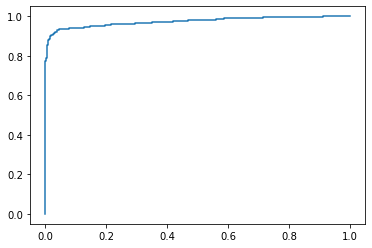

In [101]:
new_result = [1-i for i in result2]

from sklearn import metrics
from matplotlib import pyplot as plt
fpr, tpr, _ = metrics.roc_curve(result1, new_result)
auc = metrics.roc_auc_score(result1, new_result)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

In [102]:
auc

0.9735659999999999

In [95]:
testData_str_list = []
for k1, v1 in testData.items():
    templist = []
    templist.append("year_" + str(v1["year"]))
    templist.append("venue_" + str(v1["venue"]))
    templist.extend(["keywords_" + str(keyword) for keyword in v1["keywords"]])
    templist.extend(["author_" + str(author) for author in v1["coauthor"]])
    tempstr = ','.join(templist)
    testData_str_list.append([tempstr,v1["target"]]) 

In [105]:
result = [] # proba
for row in testData_str_list:
    x = vectorizer.transform([row[0]])
    filename = 'model/kpca_1/author_' + str(row[-1]) + '.sav'
    kpca = pickle.load(open(filename, 'rb'))
    filename = 'model/svdd_1/author_' + str(row[-1]) + '.sav'
    svdd = pickle.load(open(filename, 'rb'))
    x_kpca = kpca.transform(x)
    decision_func = svdd.decision_function(x_kpca)

    result.append(1 - 1/(1 + math.exp(-decision_func[0][0])))

In [109]:
x_train=[]
y_train=[]
for k,v in allData_indexed_by_author.items():
    y_train.extend([k]*len(v))
    x_train.extend(v)
    

In [112]:
x_train_transform = vectorizer.transform(x_train)

SyntaxError: cannot assign to function call (Temp/ipykernel_6476/1950876503.py, line 1)

In [106]:
import csv

header = ['Id','Predicted']
data = []
idNumber = 0
for i in result:
    data.append([idNumber,i])
    idNumber = idNumber+1

filename = 'ind_SVDD.csv'
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    csvwriter.writerows(data)

In [87]:
clf.predict_proba(X)[:, 1][19]

0.9775703378236147

In [75]:
[1, "sfewf"]+"ddd"

TypeError: can only concatenate list (not "str") to list

In [ ]:
X_train_transform = keyword_vectorizer.fit_transform(X_train["keywords"])

In [ ]:
clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

In [ ]:
def add_head(data):
    
    def join_list(l, head):
        l_str = []
        for x in l:
            l_str.append(head + "_"+  str(x))
        return ','.join(l_str)
    
    for k, v in data.items():
        v["year"] = "year_" + v["year"]
        v["venue"] = "venue" + v["venue"]
        v["keywords"] = join_list(v["keywords"], "keywords")
        v["author"] = join_list(v["author"], "author")
        

In [ ]:
# get the index of each author
authorIndexListDict = defaultdict(list)
# count the frequnecy of each author
authorCounter = defaultdict(int)

for k,v in allData.items():
    for author in v["author"]:
        authorIndexListDict[author].append(k)
        authorCounter[author] += 1
print("min freq author happen " + str(min(authorCounter, key=authorCounter.get)) + " times")

In [28]:
X_train_transform = vectorizer.fit_transform(allData_str_list)

0.14721718633145325
0.2071479722183925
0.10235797874147727
0.1694364029479834
0.09430490063326326
0.10969014853585272
0.14107496824689564
0.12717600273262294
0.16754873071001625
0.07917164325639035
0.09111923931592827
0.07256823327317678
0.14932762704350055
0.20383371901434785
0.14269508968607197
0.15901271395536387
0.2596365700079389
0.15530347517227244
0.18331158608787584
0.08389600702590844
0.11055377702886272
0.17281027985519798
0.15790457397537416
0.1432637411838393
0.09197388322688729
0.09902123415490308
0.1787739941624845
0.16034050709622139
0.0788291643334894
0.11857261867219268
0.17832767970310665
0.14444705093650162
0.07956668650733999
0.13097095707592785
0.11117970742107483
0.1379661279308203
0.14612545923076742
0.1159941672088484
0.20565171832822177
0.11642986875244181
0.09748127762079561
0.13076116431925042
0.11748684177632977
0.14742100031303917
0.121840007137888
0.3011971659769898


In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

,venue,keywords,year,author
0,,"[64, 1, 322, 134, 136, 396, 270, 144, 476, 481...",2017,"[1605, 759]"
1,0,"[258, 260, 389, 261, 390, 396, 400, 17, 146, 2...",2013,[2182]
2,1,"[320, 454, 266, 462, 17, 339, 404, 342, 407, 2...",2007,[2176]
3,2,"[260, 132, 333, 15, 400, 272, 146, 401, 278, 3...",2013,[1107]
4,3,"[64, 385, 449, 450, 71, 73, 268, 80, 216, 25, ...",2009,[1414]
...,...,...,...,...
26103,252,"[384, 320, 136, 457, 75, 17, 146, 465, 468, 21...",2011,"[656, 595]"
26104,50,"[318, 70, 457, 459, 396, 77, 146, 404, 468, 40...",2008,[876]
26105,6,"[320, 260, 69, 9, 265, 461, 156, 476, 166, 425...",2008,[535]
26106,138,"[450, 70, 198, 233, 394, 300, 492, 368, 246, 4...",2015,[1954]


In [ ]:
def join_list(l):
    l_str = []
    for x in l:
        l_str.append(str(x))
    return ','.join(l_str)

def string_comma_split(string):
    return string.split(",")

In [ ]:
with open('data/train.json') as f_all:
    all_data = json.load(f_all)

df_all = pd.DataFrame(all_data).T


In [ ]:
def get_data(df):
    
    NUM_AUTHORS = 2302
    author_vocabulary = {}
    
    def join_list(l, head):
        l_str = []
        for x in l:
            l_str.append(head + "_"+  str(x))
        return ','.join(l_str)

    def string_comma_split(string):
        return string.split(",")
    
    df['keywords'] = df['keywords'].apply((lambda x: join_list(x, "keywords")))
    df['author'] = df['author'].apply((lambda x: join_list(x, "author")))
    df['venue'] = df['venue'].apply((lambda x: join_list(x, "venue")))
    df['year'] = df['year'].apply((lambda x: join_list(x, "year")))
    df = df_all.replace('', "venue_NaN")
    df['concat'] = df.apply(lambda row: row.year + "," + row.venue + "," + row.keywords + "," + row.author )
    
    return df

In [ ]:
X_train = 

In [ ]:
NUM_KEYWORDS = 500
keyword_vocabulary = {}
for i in range(NUM_KEYWORDS):
    keyword_vocabulary[str(i)] = i

keyword_vectorizer = TfidfVectorizer(tokenizer=string_comma_split, vocabulary=keyword_vocabulary)
X_train_transform = keyword_vectorizer.fit_transform(X_train["keywords"])
X_valid_transform = keyword_vectorizer.fit_transform(X_valid["keywords"])

'fwdfwf555'

In [ ]:
with open('data/train.json') as f_train:
    train_data = json.load(f_train)

# with open('data/test.json') as f_test:
#     test_data = json.load(f_test)

# Transpose index and columns
df = pd.DataFrame(train_data).T

# View the dataframe
df

In [2]:
# Notice that keywords and author now stores lists of int64,
# Convert them into a single string => later for CountVectorizer
# This is because the tokenizer function is designed to process strings only

def join_list(l):
    l_str = []
    for x in l:
        l_str.append(str(x))
    return ','.join(l_str)

df['keywords'] = df['keywords'].apply(join_list)
df['author'] = df['author'].apply(join_list)

# Notice the venue stores empty string "", replace it with np.NaN
df = df.replace('', np.NaN)



# View updated dataframe
df



,venue,keywords,year,author
0,NaN,"64,1,322,134,136,396,270,144,476,481,165,39,36...",2017,"1605,759"
1,0.0,"258,260,389,261,390,396,400,17,146,274,21,283,...",2013,2182
2,1.0,"320,454,266,462,17,339,404,342,407,25,154,474,...",2007,2176
3,2.0,"260,132,333,15,400,272,146,401,278,342,25,346,...",2013,1107
4,3.0,"64,385,449,450,71,73,268,80,216,25,161,226,166...",2009,1414
...,...,...,...,...
26103,252.0,"384,320,136,457,75,17,146,465,468,212,342,151,...",2011,"656,595"
26104,50.0,"318,70,457,459,396,77,146,404,468,407,87,474,9...",2008,876
26105,6.0,"320,260,69,9,265,461,156,476,166,425,300,301,3...",2008,535
26106,138.0,"450,70,198,233,394,300,492,368,246,406,154,156",2015,1954


If you want to read about CountVectorizer:  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.build_tokenizer

In [3]:
def string_comma_split(string):
    return string.split(",")

NUM_AUTHORS = 2302
author_vocabulary = {}
for i in range(NUM_AUTHORS):
    author_vocabulary[str(i)] = i
        
# 
author_vectorizer = CountVectorizer(tokenizer=string_comma_split, vocabulary=author_vocabulary)
y_multilabel = author_vectorizer.fit_transform(df['author'])

API for scipy sparse matrix:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [4]:
# You may skip the following cell
# example check: author ids of paper 26103:
instance = y_multilabel.toarray()[26103]
for i in range(NUM_AUTHORS):
    if instance[i] == 1:
        print(i)

595
656


In [5]:
#WARINING: should use StratifiedShuffleSplit to search for best kernal parameters, for now, just 
X_train, X_valid, y_train, y_valid = train_test_split(df, y_multilabel, test_size=2000, random_state=18)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

NUM_KEYWORDS = 500
keyword_vocabulary = {}
for i in range(NUM_KEYWORDS):
    keyword_vocabulary[str(i)] = i

keyword_vectorizer = TfidfVectorizer(tokenizer=string_comma_split, vocabulary=keyword_vocabulary)
X_train_transform = keyword_vectorizer.fit_transform(X_train["keywords"])
X_valid_transform = keyword_vectorizer.fit_transform(X_valid["keywords"])

In [63]:
# v = CountVectorizer(tokenizer=string_comma_split, vocabulary=keyword_vocabulary)
# test = v.fit_transform(df["keywords"])

# instance = test.toarray()[26106]
# for i in range(NUM_KEYWORDS):
#     if instance[i] == 1:
#         print(i)


For multilabel classification:
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [7]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
cbsvm() = CalibratedClassifierCV(svm)
clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

In [8]:
clf.fit(X_train_transform, y_train)

OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

In [35]:
y_train_pred_proba = clf.predict_proba(X_train_transform)
y_valid_pred_proba = clf.predict_proba(X_valid_transform)

In [36]:
from sklearn.metrics import roc_auc_score

In [84]:
# roc_auc_score_train = roc_auc_score(y_train.toarray(), y_train_pred_proba,average='weighted')
# roc_auc_score_test = roc_auc_score(y_valid.toarray(), y_valid_pred_proba,average='weighted')

In [37]:
import copy
y1 = [row[1] for row in y_valid.toarray()]
y2 = [row[1] for row in y_valid_pred_proba]

In [45]:
type(X_train_transform)
type(y_train)

scipy.sparse.csr.csr_matrix

In [38]:
roc_auc_score(y1, y2)

0.9915708812260536

In [9]:
with open('data/test.json') as f_test:
    test_data = json.load(f_test)

df_test = pd.DataFrame(test_data).T
df_test['keywords'] = df_test['keywords'].apply(join_list)
# df_test['coauthor'] = df_test['coauthor'].apply(join_list)
df_test = df_test.replace('', np.NaN)

In [10]:
# y_multilabel_test = author_vectorizer.transform(df_test['target'])
X_test_transform = keyword_vectorizer.transform(df_test["keywords"])

In [15]:
y_test_pred_decision_function = clf.decision_function(X_test_transform)

import math
def decision_function_to_proba(dcfn):
    return 1/(1+math.exp(-dcfn))

In [23]:
results_test = []
counter = 0
for item in list(df_test['target']):
    results_test.append(decision_function_to_proba(y_test_pred_decision_function[counter][item]))
    counter += 1


In [21]:
len(results_test)

2000

In [24]:
import csv

header = ['Id','Predicted']
data = []
idNumber = 0
for i in results_test:
    data.append([idNumber,i])
    idNumber = idNumber+1

filename = 'multi_label_LinearSVM.csv'
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    csvwriter.writerows(data)